In [1]:
import os.path
from scipy import *
import scipy as sp
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
import math as math
from math import factorial as fact

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 128
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 1
deriv = 'CD'
order = 1

In [3]:
omega = BT.Grid(nh)
# finehalf = list(np.arange(int(nh / refRatio)) + int(nh / refRatio))
# omega.AddPatch(refRatio, finehalf)
nh_min = omega.nh_min
waves = WT.MakeWaves(omega)
print(waves)

[[ 1.          0.02453876  0.99959845  0.04904797  0.99839439  0.07349811  0.99638956  0.09785976  0.99358685  0.12210366  0.98999032  0.14620071  0.98560515  0.17012208  0.98043768  0.19383918  0.97449536  0.21732378  0.96778676  0.24054802  0.96032155  0.26348445  0.95211046  0.28610607  0.94316532  0.3083864   0.93349897  0.33029951  0.92312528  0.35182002  0.91205911  0.37292323  0.90031632  0.39358506  0.88791367  0.41378216  0.87486887  0.4334919   0.8612005   0.45269244  0.84692799  0.47136274  0.83207161  0.4894826   0.81665238  0.50703269  0.80069212  0.52399458  0.7842133   0.54035076  0.76723913  0.55608469  0.7497934   0.57118078  0.73190053  0.58562448  0.71358549  0.59940221  0.69487374  0.61250146  0.67579123  0.62491078  0.65636432  0.63661977  0.63661977  0.64761913  0.61658467  0.65790063  0.59628638  0.66745718  0.57575253  0.67628278  0.55501094  0.68437255  0.53408958  0.69172273  0.51301654  0.69833068  0.49181995  0.70419489  0.47052798  0.70931496  0.44916875  0

In [4]:
def ModeProp(omega, nt, c, CFL, deriv, RK):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    
    if (RK == 1):
        TimeIntegratorFunc = ST.ForwardEuler
    else:
        if (RK == 2):
            TimeIntegratorFunc = ST.MidpointMeth
        else:
            TimeIntegratorFunc = ST.RK4

    if (deriv == 'U'):
        # DiffMatFunc = OT.Upwind1D
        DiffFunc = TT.Upwind#ST.Upwind
    else:
        # DiffMatFunc = OT.CenterDiff1D
        DiffFunc = TT.CenterDiff#ST.CenterDiff

    t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
    derivMat = OT.SpaceDeriv(omega, order, deriv)
    spatOp = -c * derivMat
    strings = omega.strings
    timePropOp = LA2.expm(t * spatOp)
    waves = WT.MakeWaves(omega)
    omegaF = BT.Grid(nh_max)
    wavesF = WT.MakeWaves(omegaF)
    restrictOp = GTT.CoarsenOp(omega)
    nullspace = OT.FindNullspace(omega, waves)
    
    FCoefsF = np.eye(nh_max)# [:, :nh_min]
    FCoefs = np.zeros((degFreed, nh_max), float)
    propFCoefs = np.zeros((degFreed, nh_max), float)
    solvFCoefs = np.zeros((degFreed, nh_max), float)
    exTimeCoefs = np.zeros((degFreed, nh_max), float)
    
#     print('derivMat =\n', derivMat, '\n')
#     print('spatOp =\n', spatOp, '\n')
#     print('timePropOp =\n', timePropOp, '\n')

    for k in range(nh_max):
        waveformF = wavesF @ FCoefsF[:, k] # nullspace[:, k]
        propFCoefs[:, k] = FFTT.PropRestrictWaves(omega, waveformF, c, t)
        waveform = restrictOp @ waveformF
        FCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

        solvFCoefs[:, k] = TimeIntegratorFunc(omega, waves @ nullspace, waveform, nt, c, CFL, DiffFunc)
        exTimeForm = timePropOp @ waveform
        exTimeCoefs[:, k] = FFTT.FourierCoefs(omega, waves @ nullspace, exTimeForm)
    
    propFCoefs = nullspace @ propFCoefs
    solvFCoefs = nullspace @ solvFCoefs
    exTimeCoefs = nullspace @ exTimeCoefs
    return propFCoefs, solvFCoefs, exTimeCoefs


In [5]:
def ModeError(omega, nt, c, CFL, deriv, RK, normType = 'max', errorType = 'absolute'):
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    nh_max = omega.nh_max
    n = int((nh_max / 2) + 2)
    propFCoefs, solvFCoefs, exTimeCoefs = ModeProp(omega, nt, c, CFL, deriv, RK)
    solvError = np.zeros(nh_max, float)
    exTimeError = np.zeros(nh_max, float)
    solvNorm = np.zeros(nh_max, float)
    for k in range(nh_max):
        ks, solvErrorVec = TT.AmpError(omega, propFCoefs[:, k], solvFCoefs[:, k])
        ks, exTimeErrorVec = TT.AmpError(omega, propFCoefs[:, k], exTimeCoefs[:, k])
        
        title = 'Amplitude Norm Error for Mode ' + str(k)
        fig, ax = plt.subplots(figsize = [20, 6])
        plt.plot(ks, solvErrorVec, label = 'Solver Error', color = PT.ColorDefault(0))
        plt.scatter(ks, solvErrorVec, color = PT.ColorDefault(0))
        plt.plot(ks, exTimeErrorVec, label = 'Exact Time Error', color = PT.ColorDefault(1))
        plt.scatter(ks, exTimeErrorVec, color = PT.ColorDefault(1))
        plt.title(title)
        plt.xlabel('Wavenumber')
        plt.ylabel('Error')
        plt.legend()
        # plt.ylim(-1, 1.1)
        plt.show()
        
        if (normType == 'max'):
            solvError[k] = max(solvErrorVec)
            exTimeError[k] = max(exTimeErrorVec)
            solvNorm[k] = max(solvFCoefs[:, k])
        else:
            solvError[k] = sum(solvErrorVec) / nh_max
            exTimeError[k] = sum(exTimeErrorVec) / nh_max
            solvNorm[k] = sum(solvFCoefs[:, k]) / nh_max
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    return ks, solvError, exTimeError , solvNorm

Actual:
[ 1.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -1.e-15  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -1.e-15 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00

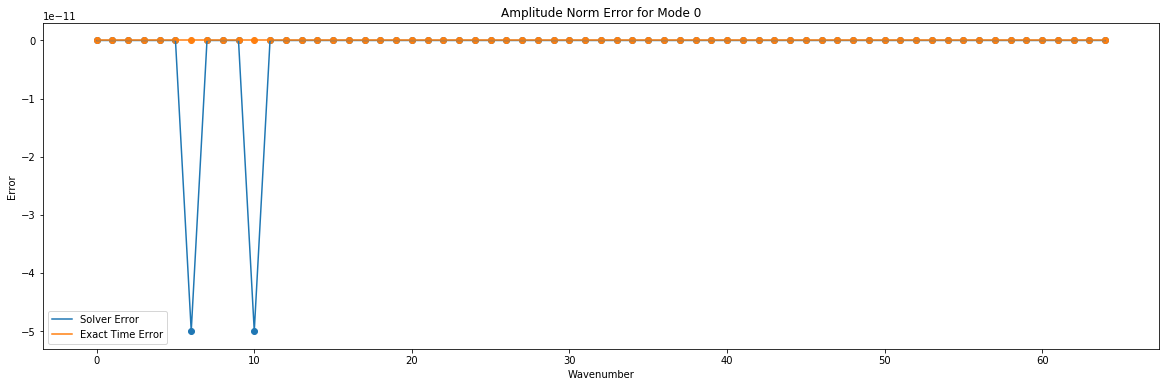

Actual:
[-0.00000000e+00  1.00000000e+00 -9.81353487e-02 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -3.00000000e-15  4.00000000e-15  0.00000000e+00  1.00000000e-15  3.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15

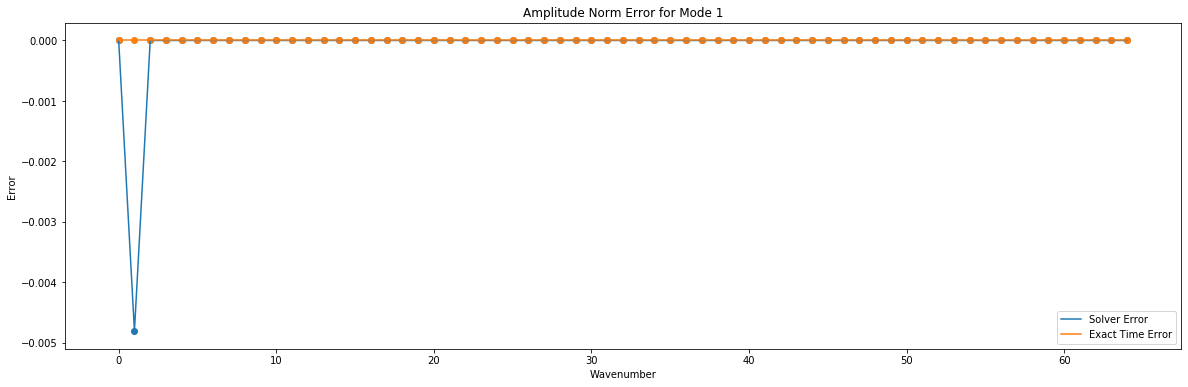

Actual:
[-0.00000000e+00  9.81353487e-02  1.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  2.00000000e-15 -3.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15

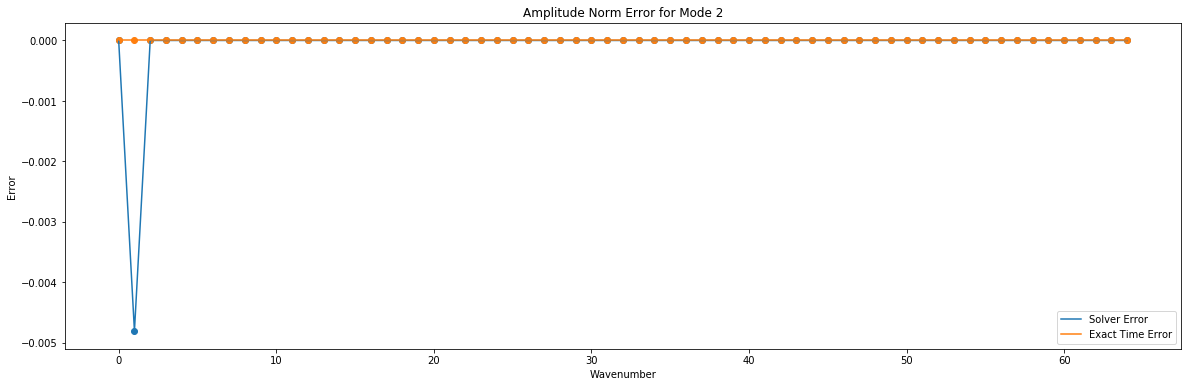

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00 -1.96034281e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -3.00000000e-15  2.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00

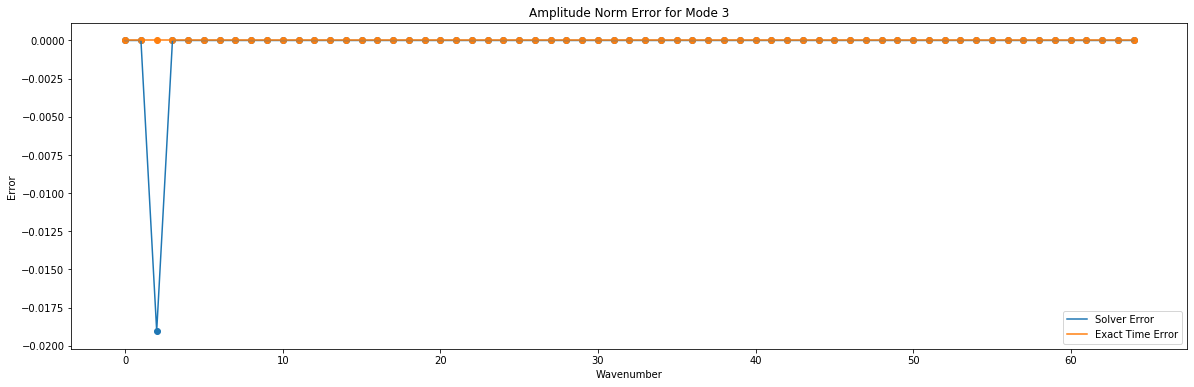

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.96034281e-01  1.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15 -3.00000000e-15 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00

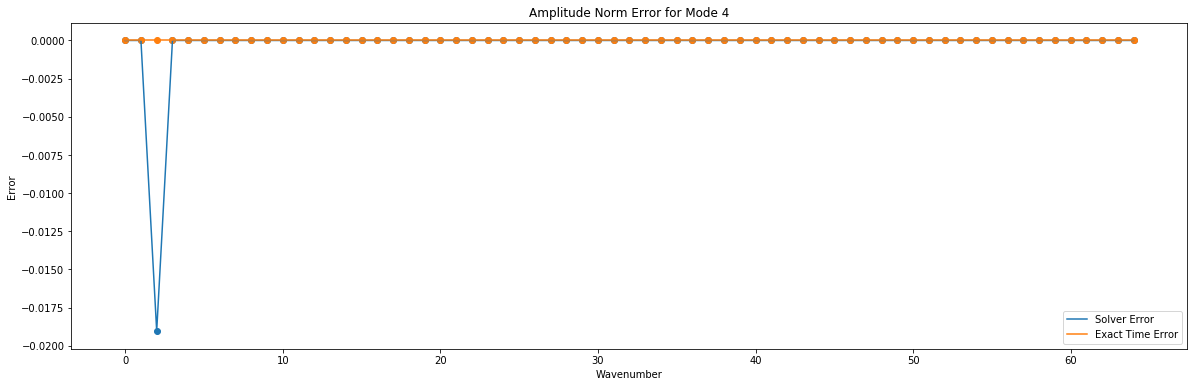

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e+00 -2.93460949e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15

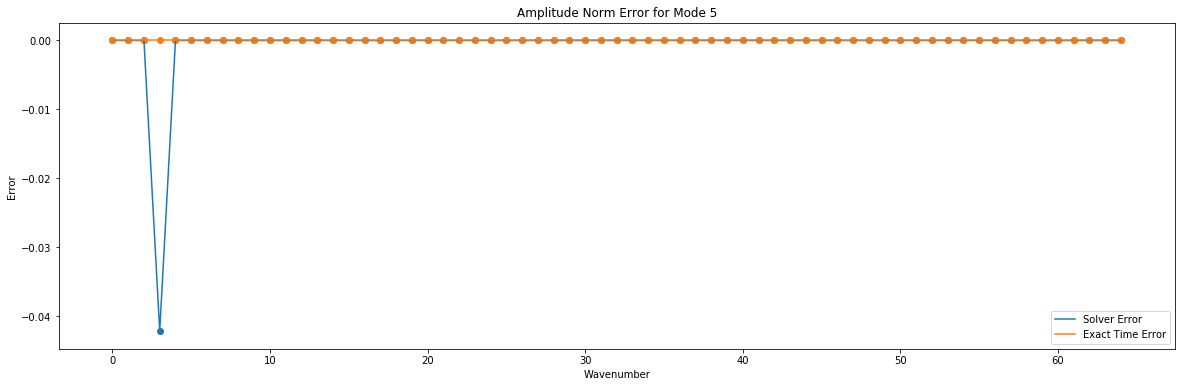

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.93460949e-01  1.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00

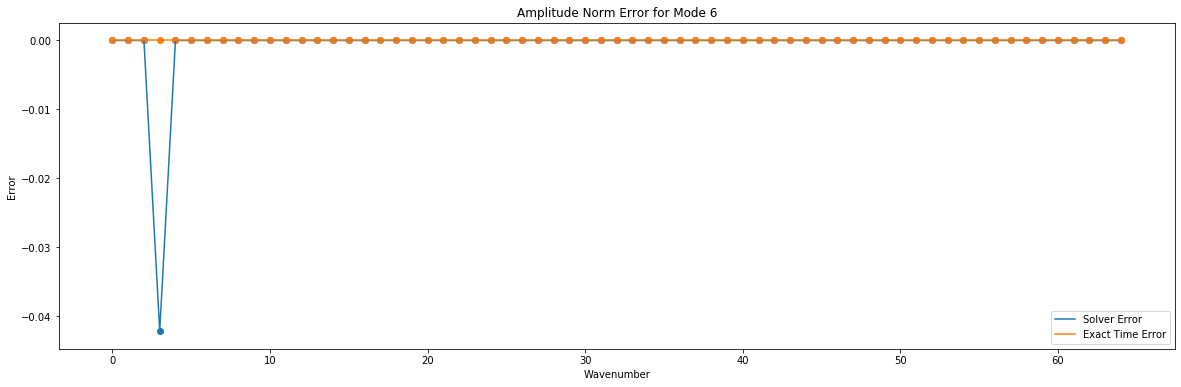

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00 -3.90180644e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -3.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00  2.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15

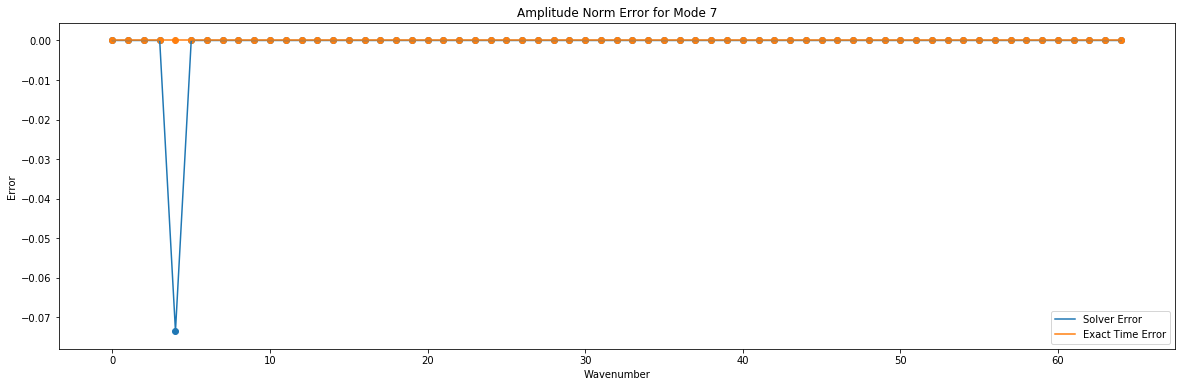

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  3.90180644e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.00000000e-15 -3.00000000e-15  0.00000000e+00 -0.00000000e+00 -2.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  2.00000000e-15 -4.00000000e-15 -0.00000000e+00 -0.00000000e+00 -3.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00

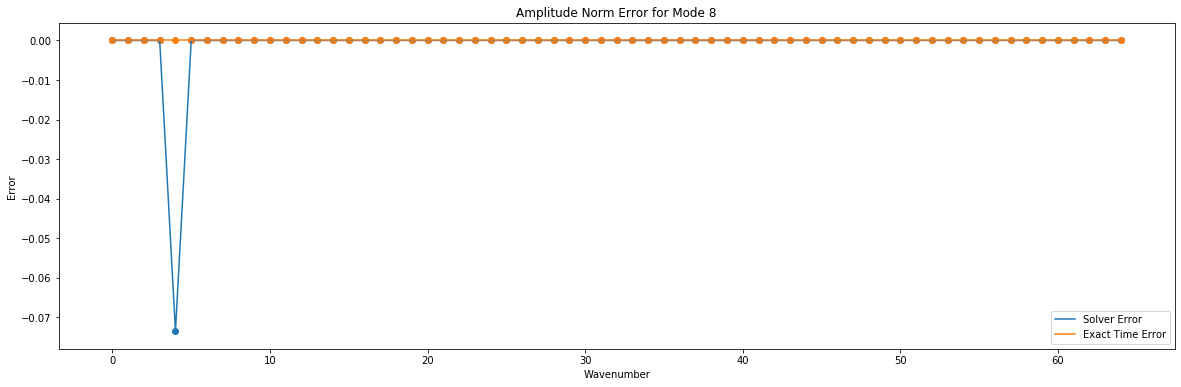

Actual:
[-0.0000000e+00  1.0000000e-15  0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00 -4.8596036e-01 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.0000000e-15 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e-15 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  1.0000000e-15 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00 -1.0000000e-15  1.0000000e-15 -0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e-15  1.0000000e-15 -0.0000000e+00  0.0000000e+00  1.0000000e-15 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  2.0000000e-15  1.0000000e-15 -1.0000000e-15  5.0000000e-15 -2.0000000e-15 -0.0000000e+00  1.0000000e-15  1.0000000e-15 -2.0000000e-15  1.0000000e-15 -0.0000000e+00 -

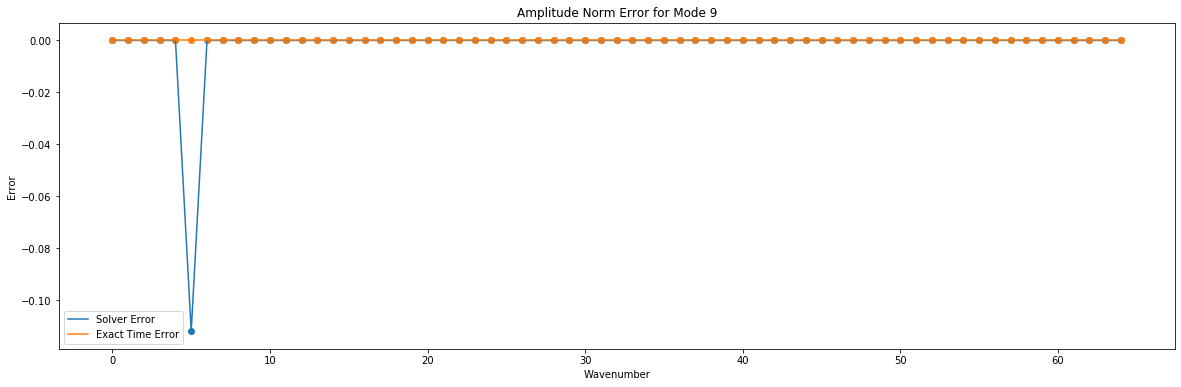

Actual:
[-0.0000000e+00 -1.0000000e-15  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  4.8596036e-01  1.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  1.0000000e-15 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15  1.0000000e-15 -1.0000000e-15 -0.0000000e+00  0.0000000e+00 -1.0000000e-15 -0.0000000e+00  0.0000000e+00  1.0000000e-15 -1.0000000e-15  0.0000000e+00 -0.0000000e+00  0.0000000e+00 -1.0000000e-15 -1.0000000e-15 -0.0000000e+00  0.0000000e+00 -3.0000000e-15  3.0000000e-15 -0.0000000e+00  1.0000000e-15  3.0000000e-15 -1.0000000e-15 -0.0000000e+00  1.0000000e-15 -0.0000000e+00 -0.0000000e+00  

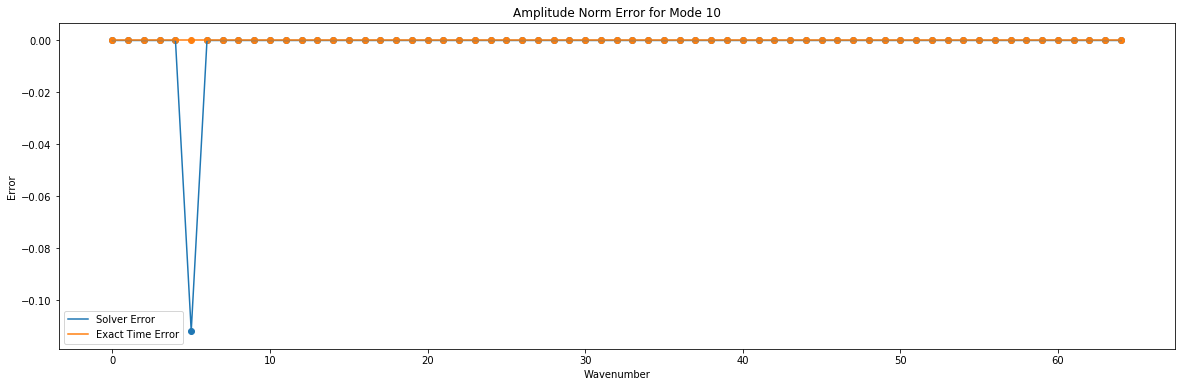

Actual:
[ 0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00 -5.80569355e-01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -2.00000000e-15  2.00000000e-15

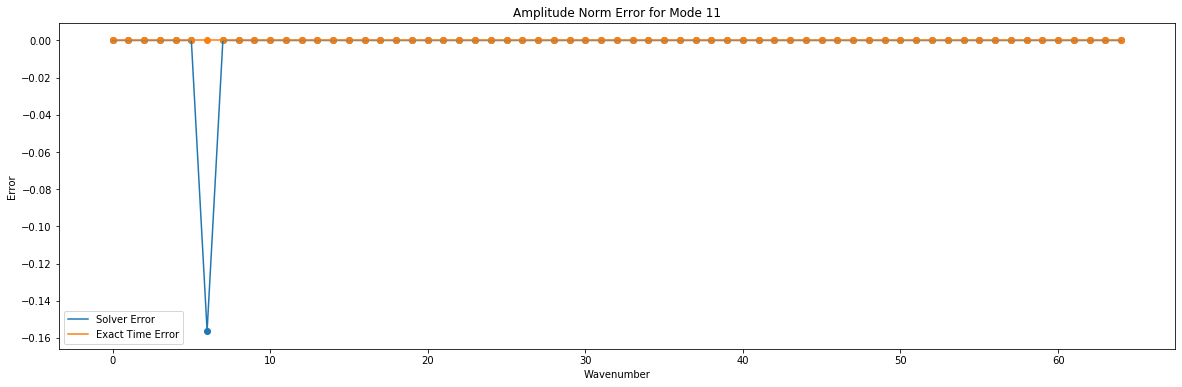

Actual:
[-1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  5.80569355e-01  1.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -2.00000000e-15 -0.00000000e+00  3.00000000e-15

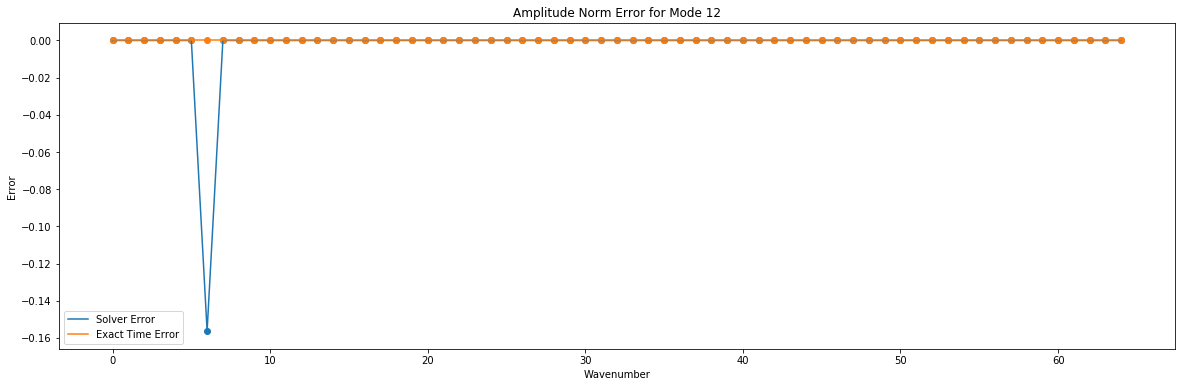

Actual:
[ 1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00 -6.73779707e-01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  2.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15

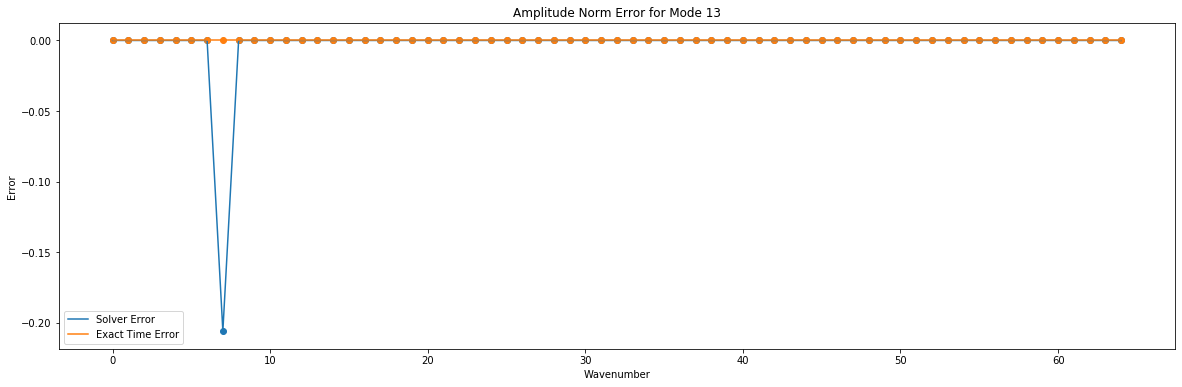

Actual:
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  6.73779707e-01  1.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15  0.00000000e+00  1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15

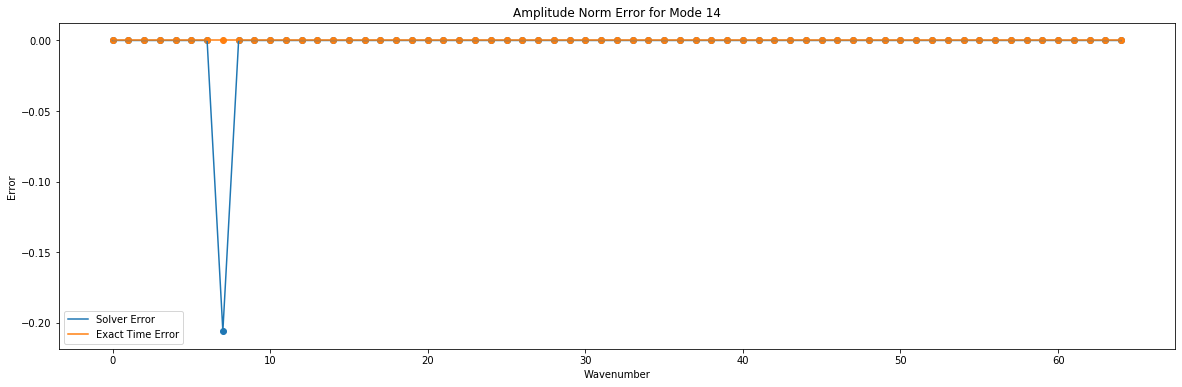

Actual:
[-0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -7.65366865e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -2.00000000e-15  2.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.00000000e-15

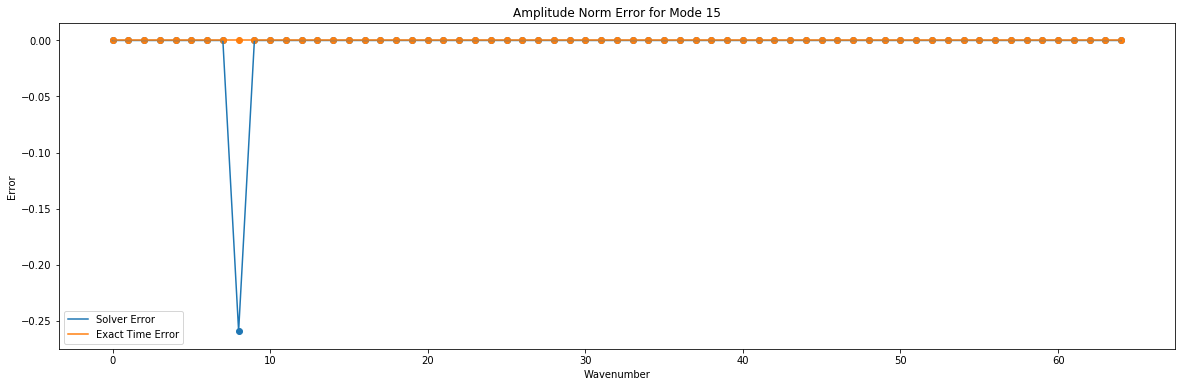

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  7.65366865e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00

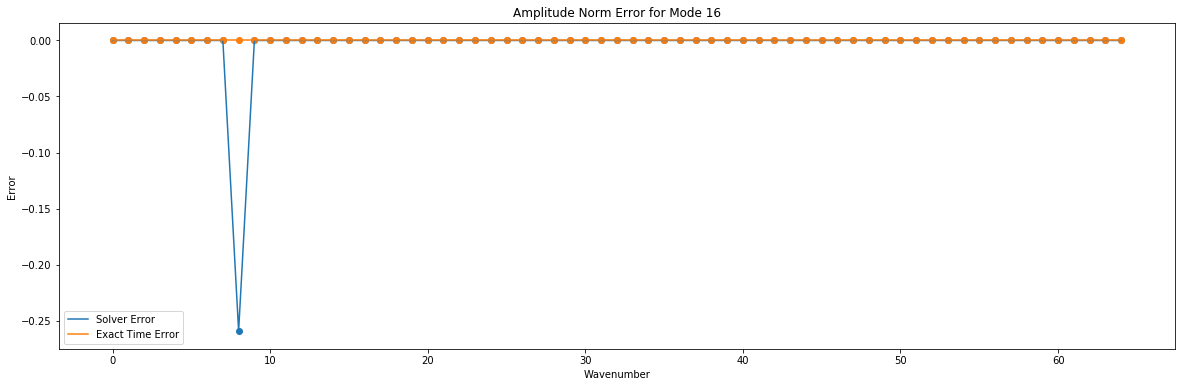

Actual:
[ 1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -8.55110187e-01 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15

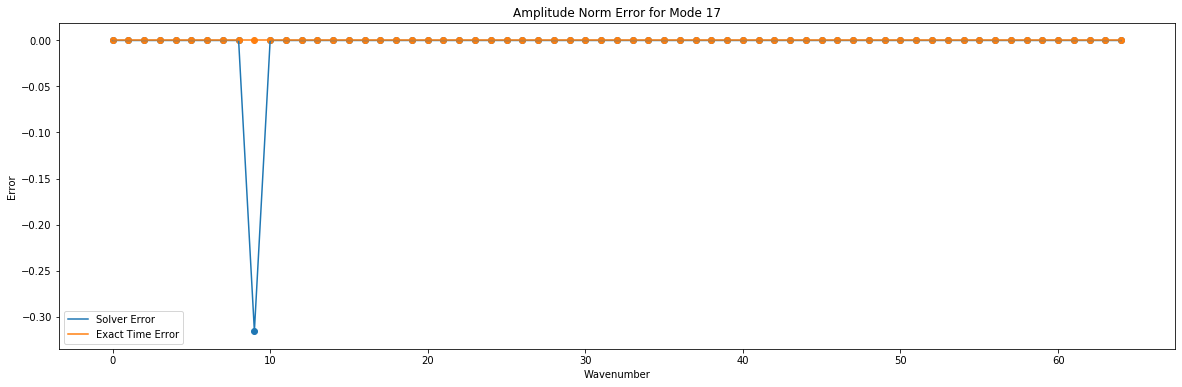

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  8.55110187e-01  1.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.00000000e-15

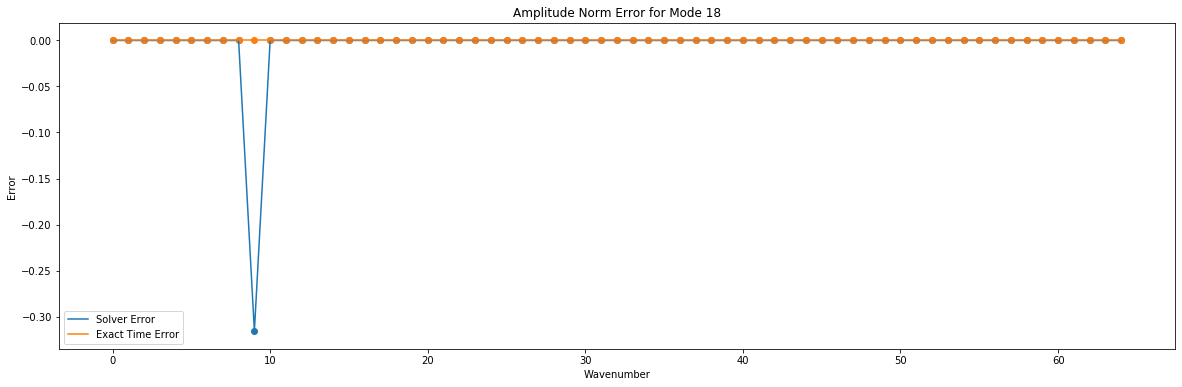

Actual:
[ 0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -9.42793474e-01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  3.00000000e-15 -1.00000000e-15  0.00000000e+00  3.00000000e-15 -2.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00

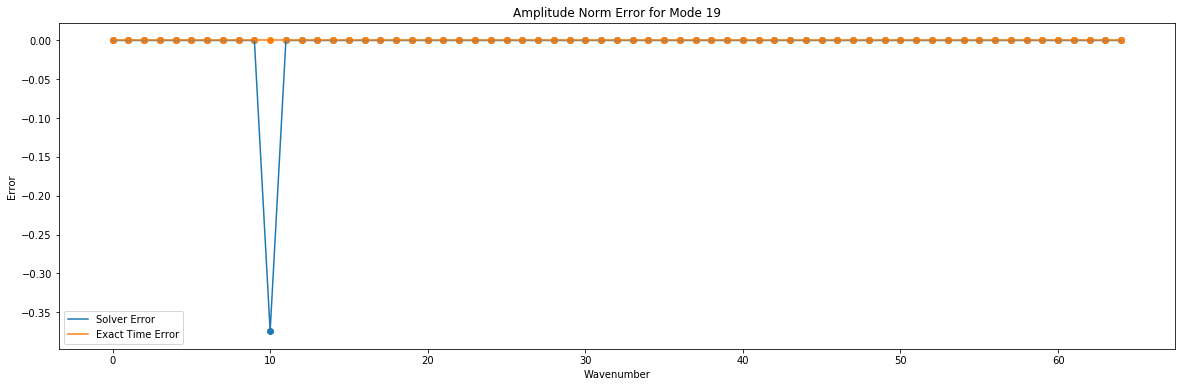

Actual:
[-0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  9.42793474e-01  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  4.00000000e-15  0.00000000e+00  0.00000000e+00  2.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15

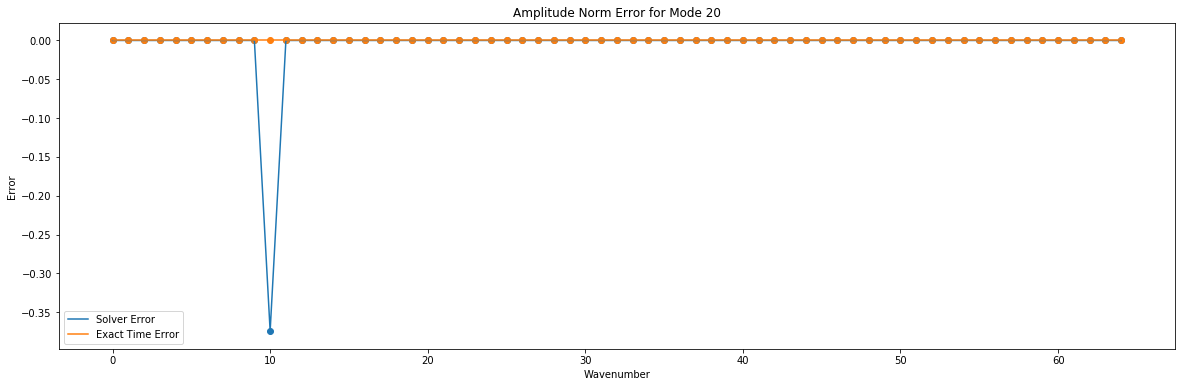

Actual:
[ 1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00 -1.02820549e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00

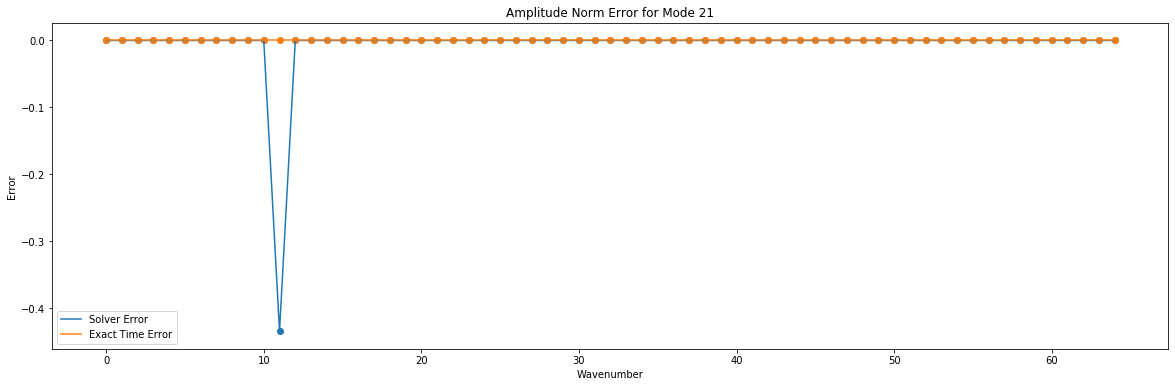

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.02820549e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15

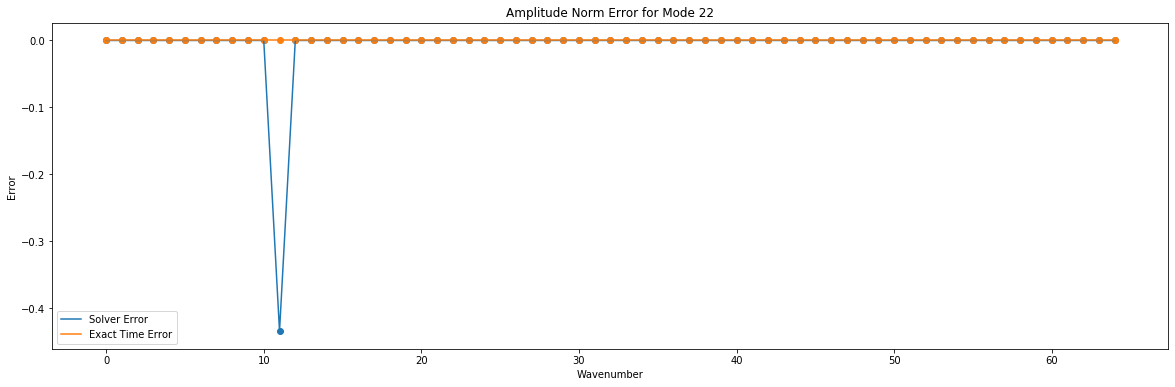

Actual:
[ 0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -1.11114047e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -2.00000000e-15  2.00000000e-15  3.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -1.00000000e-15  2.00000000e-15

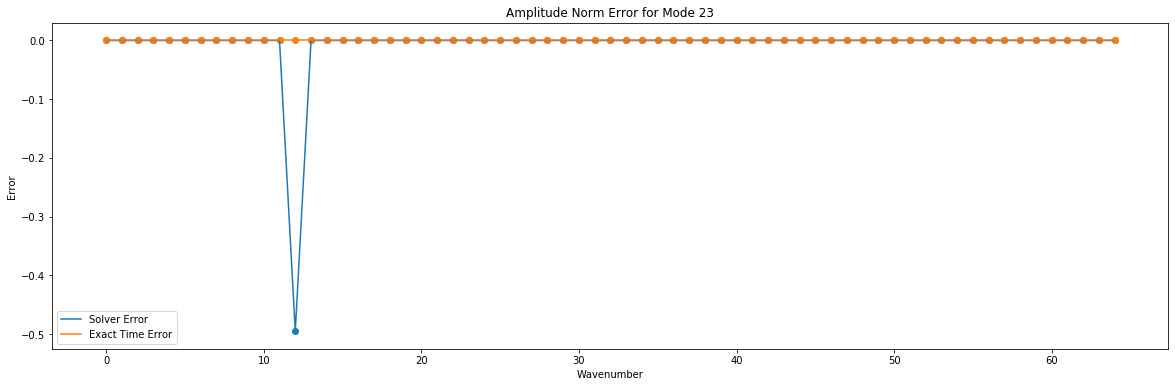

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.11114047e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -2.00000000e-15  0.00000000e+00  3.00000000e-15 -2.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00  2.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15 -2.00000000e-15  1.00000000e-15

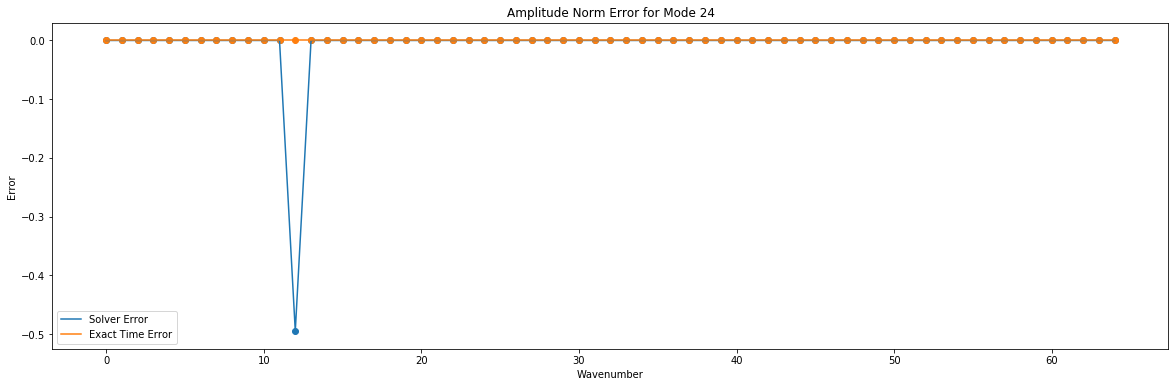

Actual:
[ 1.00000000e-15  2.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.19139861e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -2.00000000e-15 -2.00000000e-15  1.00000000e-15 -3.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -1.00000000e-15  2.00000000e-15 -0.00000000e+00  2.00000000e-15 -0.00000000e+00 -0.00000000e+00

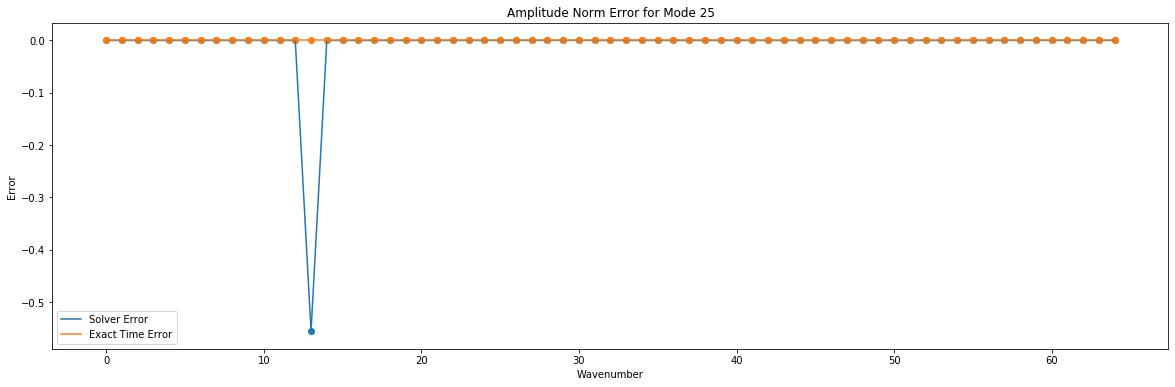

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.19139861e+00  1.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  2.00000000e-15 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  2.00000000e-15 -3.00000000e-15 -0.00000000e+00 -2.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  2.00000000e-15

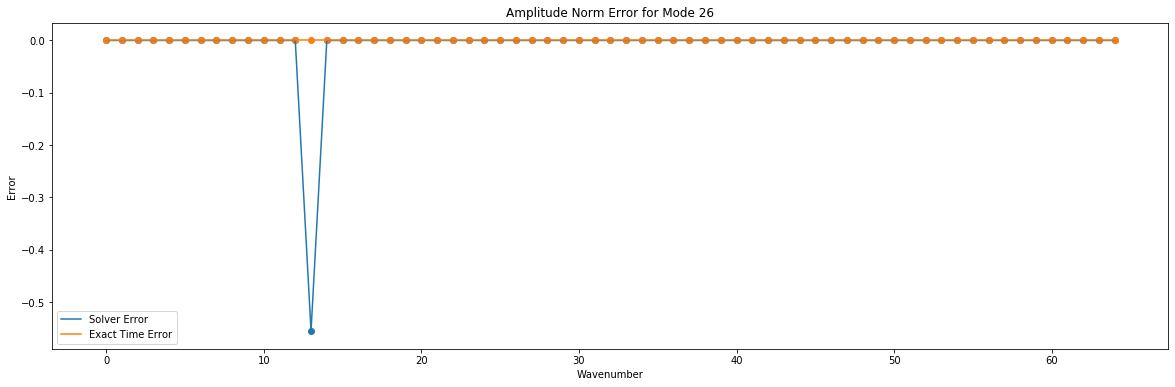

Actual:
[ 1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00 -1.26878657e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.00000000e-15 -0.00000000e+00  2.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -2.00000000e-15  0.00000000e+00  0.00000000e+00 -2.00000000e-15  1.00000000e-15

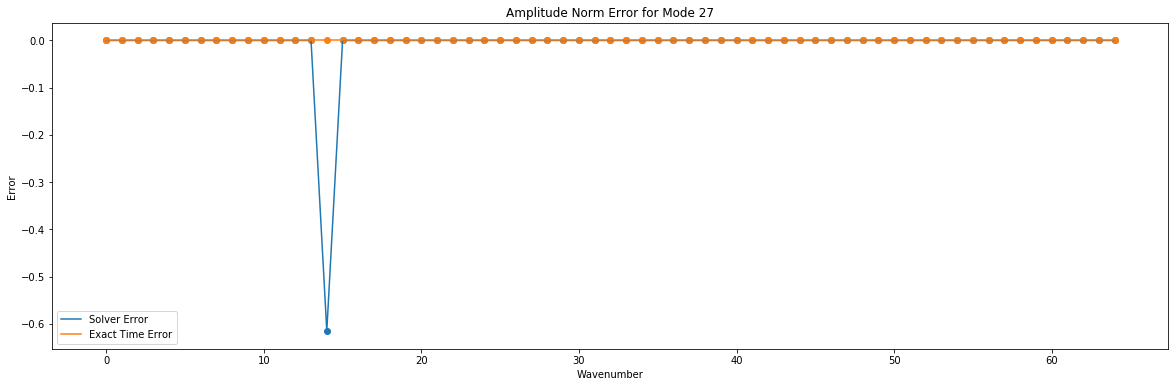

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.26878657e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  2.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  2.00000000e-15 -2.00000000e-15  0.00000000e+00  1.00000000e-15

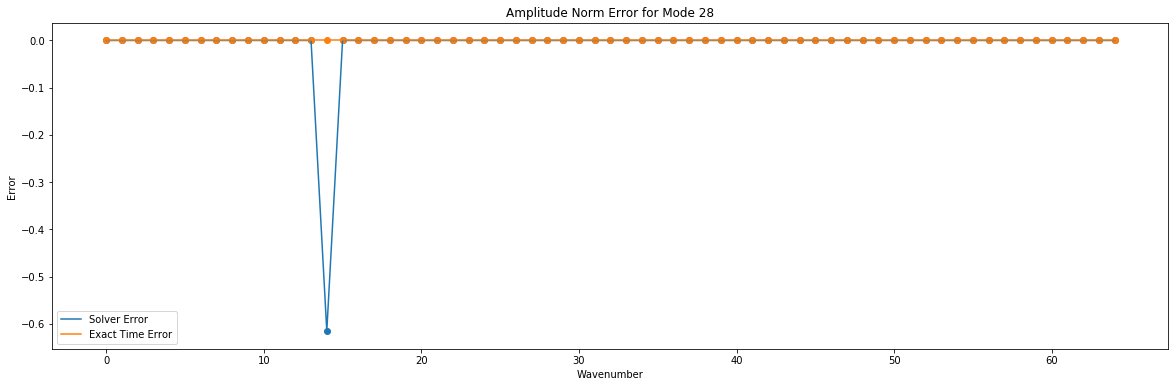

Actual:
[-0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e+00 -1.34311791e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00

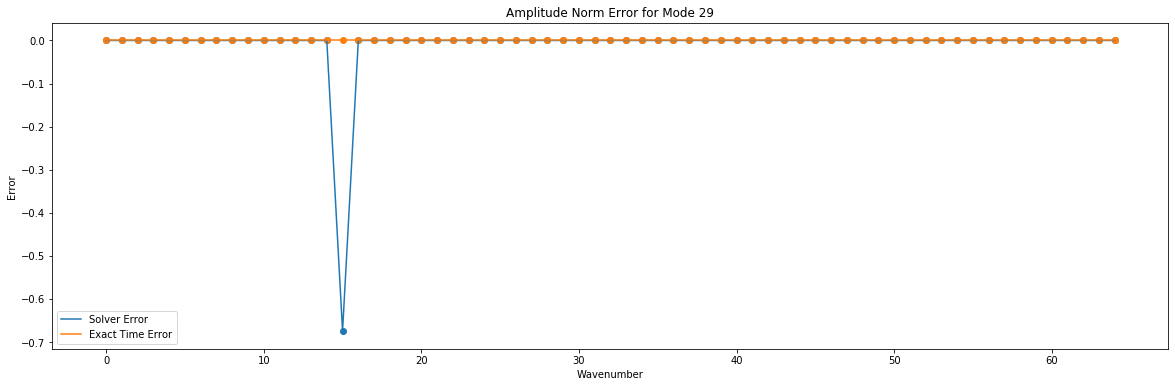

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.34311791e+00  1.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15

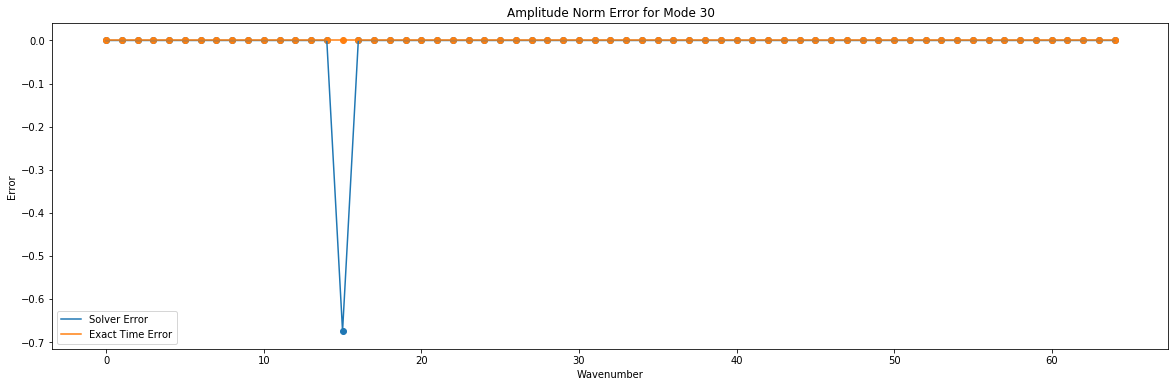

Actual:
[ 0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.41421356e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  3.00000000e-15

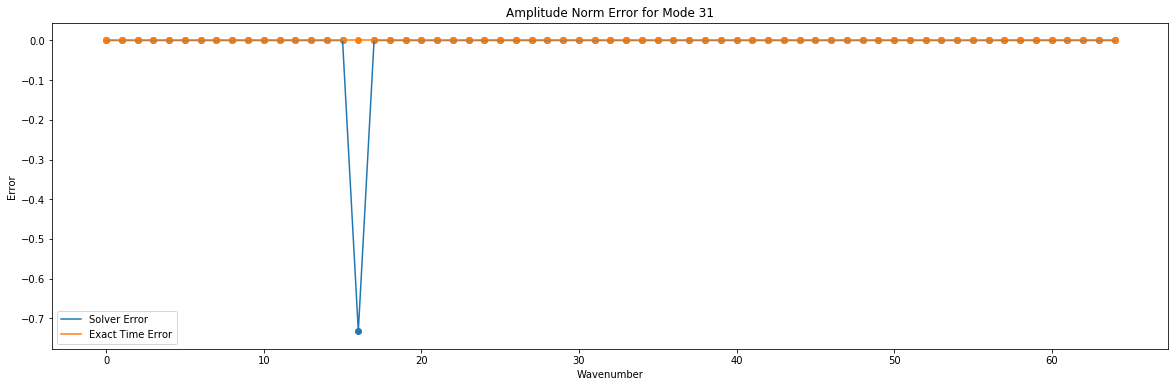

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.41421356e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  2.00000000e-15

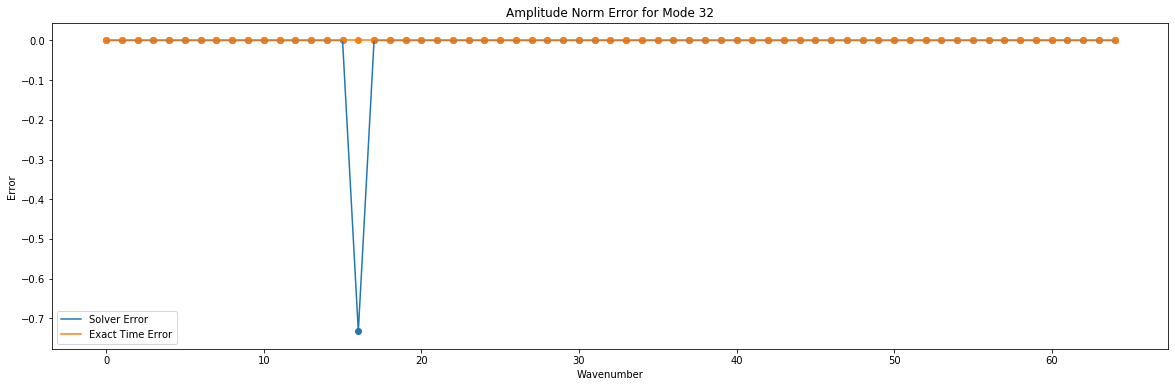

Actual:
[ 0.00000000e+00  1.00000000e-15  0.00000000e+00  2.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e+00 -1.48190225e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  2.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -2.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15 -1.00000000e-15  2.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15

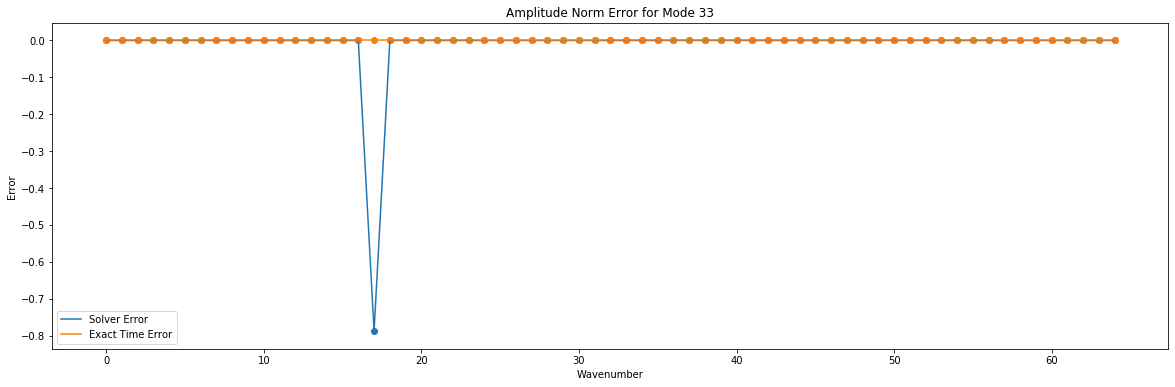

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.48190225e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -2.00000000e-15  2.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15

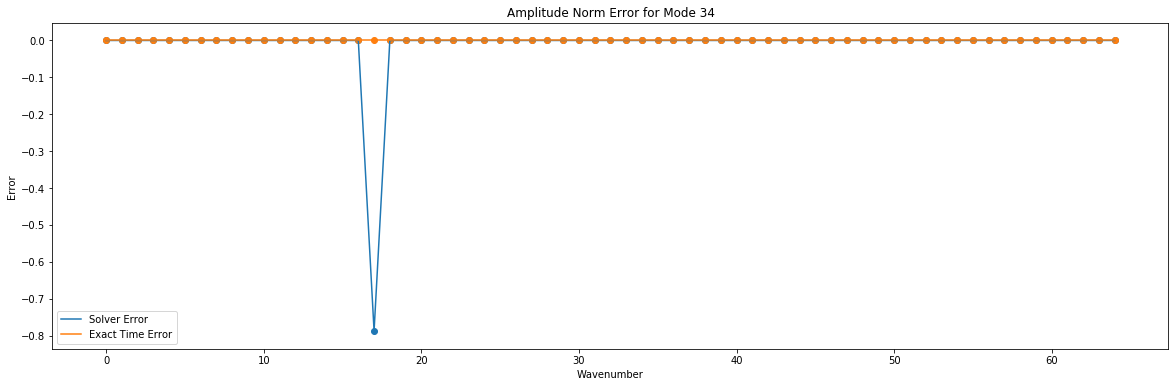

Actual:
[ 0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.54602091e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15

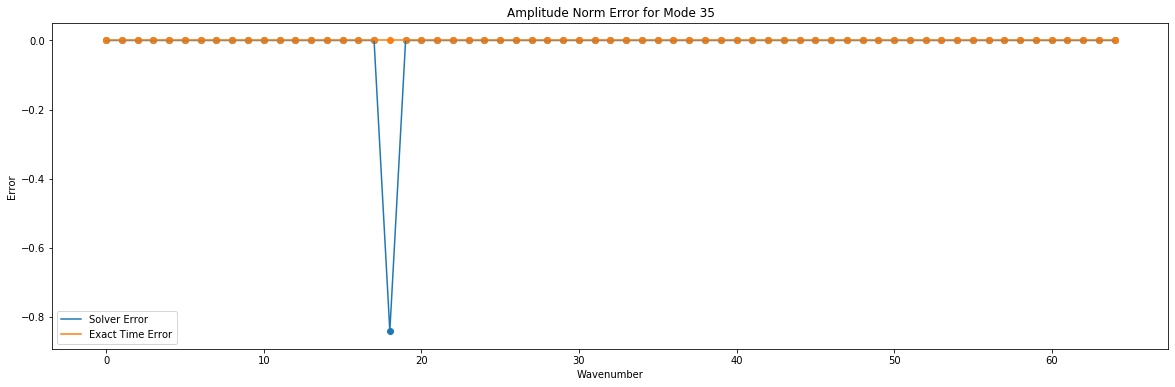

Actual:
[ 0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.54602091e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -3.00000000e-15

[-0.         -0.          0.          0.         -0.          0.          0.         -0.          0.          0.         -0.          0.          0.          0.         -0.         -0.          0.         -0.          0.          0.         -0.         -0.         -0.         -0.         -0.          0.         -0.         -0.         -0.         -0.          0.          0.          0.          0.          0.          0.42755509  0.90398929 -0.          0.         -0.         -0.          0.         -0.          0.          0.         -0.         -0.          0.          0.          0.         -0.         -0.         -0.         -0.         -0.         -0.          0.          0.          0.          0.         -0.         -0.          0.         -0.         -0.          0.          0.         -0.         -0.          0.          0.          0.         -0.         -0.          0.          0.         -0.         -0.         -0.          0.         -0.          0.         -0.          0.

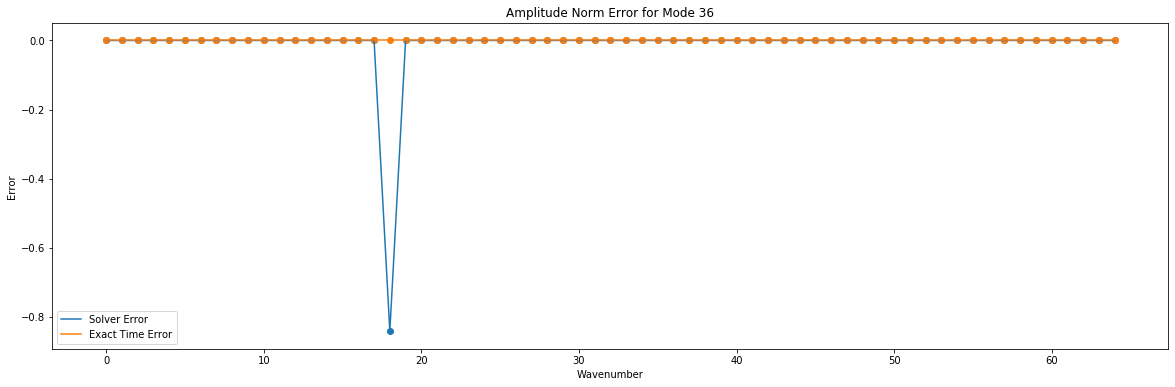

Actual:
[ 1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.60641506e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  2.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00

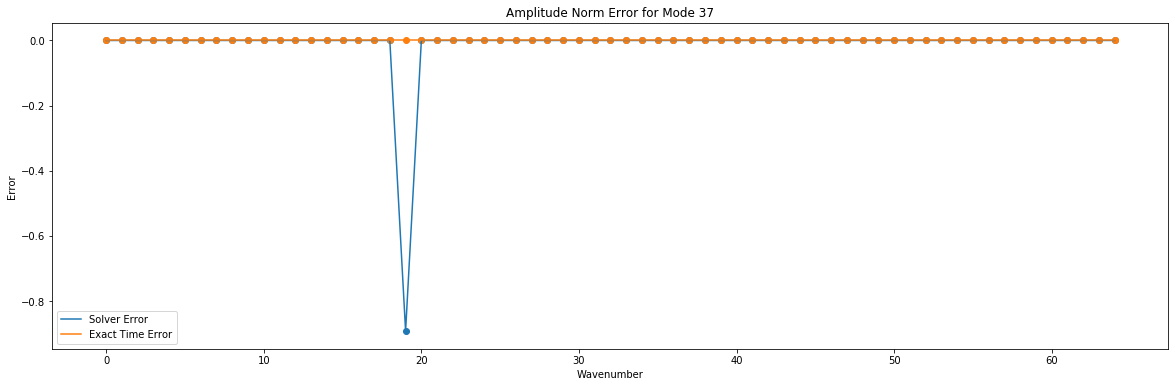

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -2.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.60641506e+00  1.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00

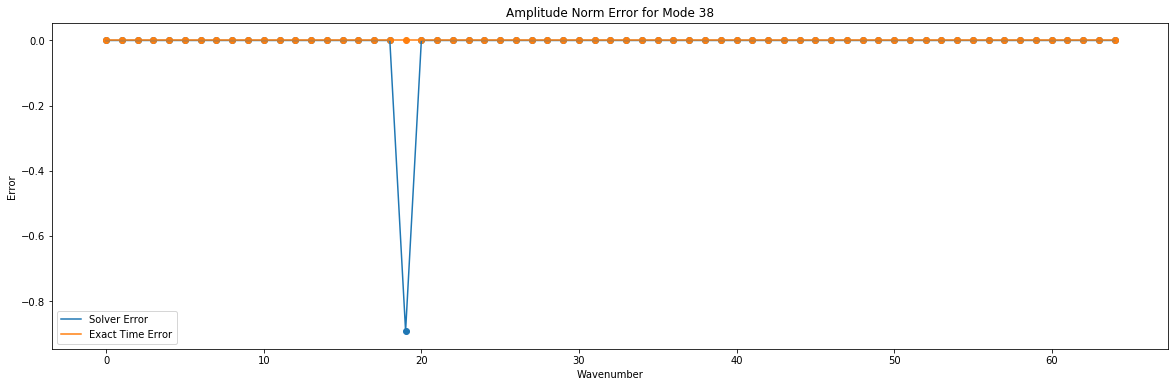

Actual:
[-0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  2.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -1.66293922e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15

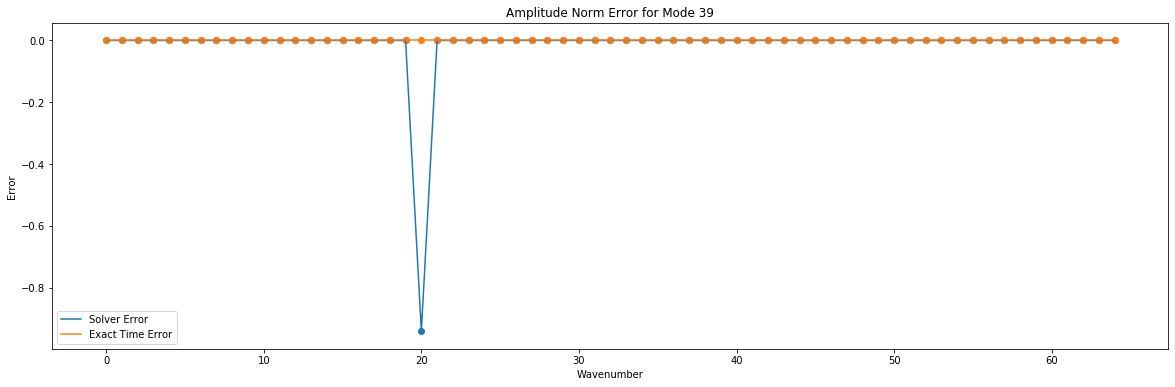

Actual:
[-0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -2.00000000e-15  2.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.66293922e+00  1.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15

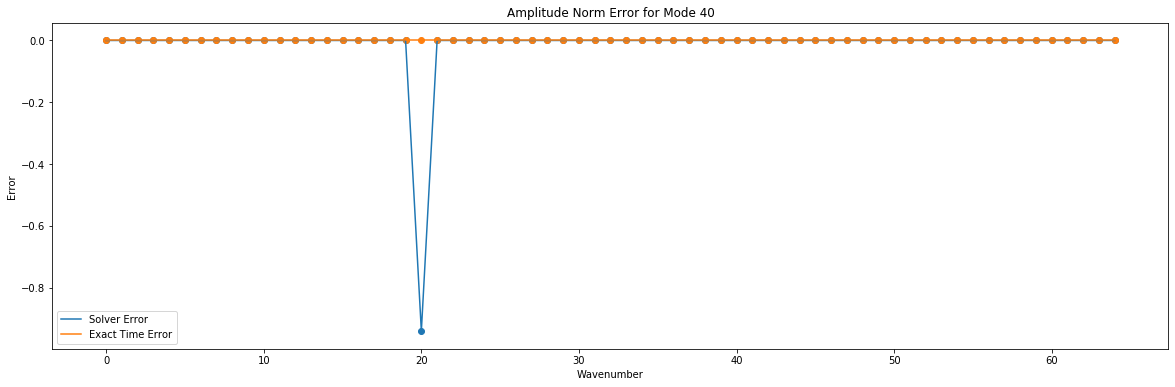

Actual:
[ 1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e+00 -1.71545722e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -2.00000000e-15  1.00000000e-15  1.00000000e-15 -5.00000000e-15  3.00000000e-15  2.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15

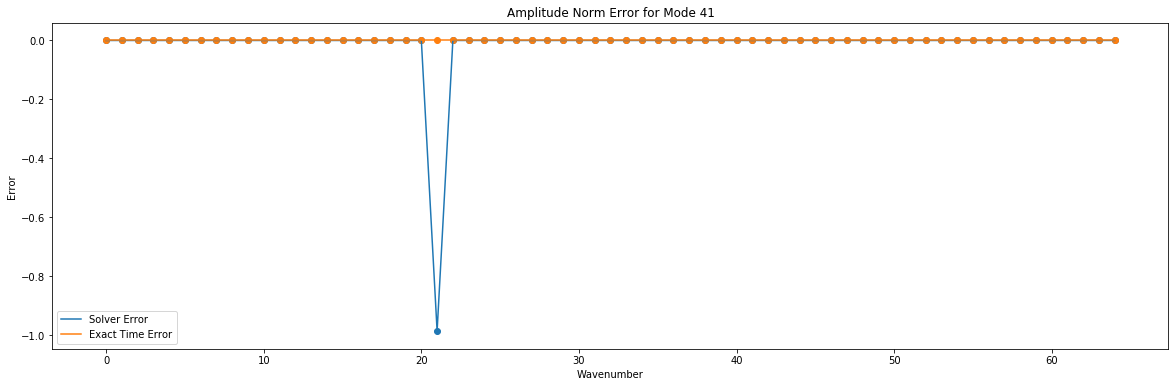

Actual:
[-1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.71545722e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  2.00000000e-15 -5.00000000e-15 -0.00000000e+00  2.00000000e-15 -3.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15

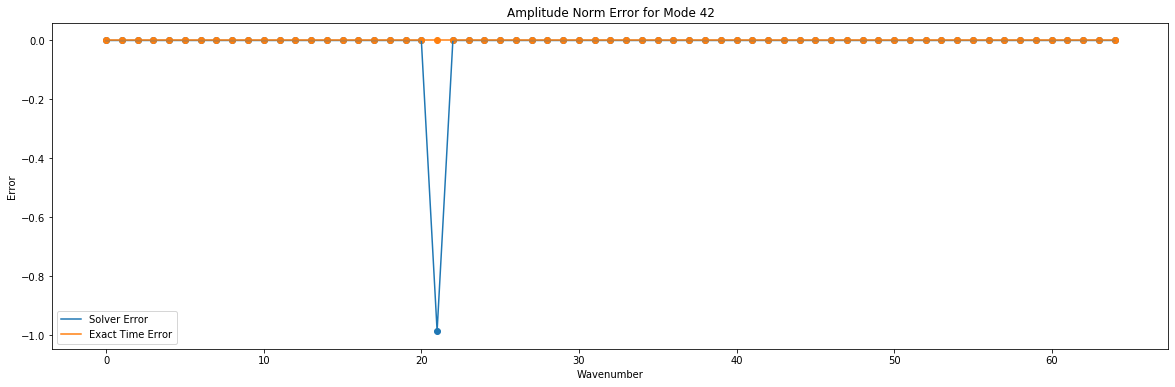

Actual:
[ 1.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -2.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e+00 -1.76384253e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15

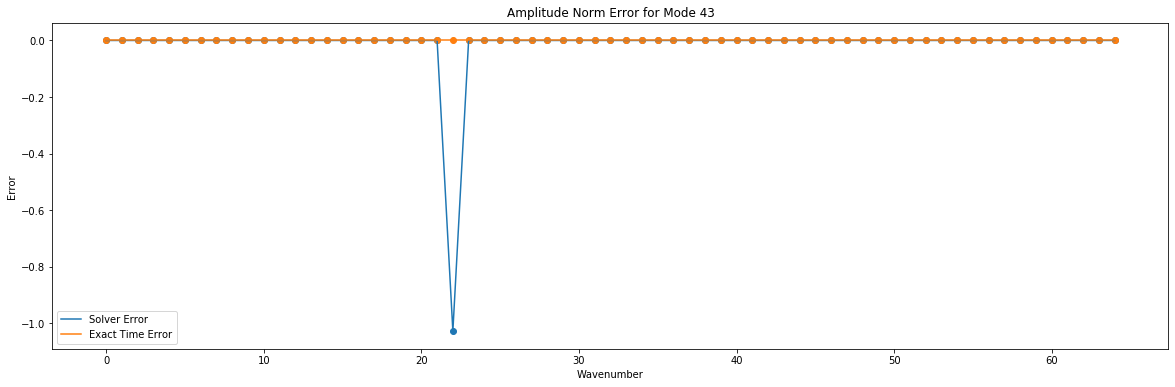

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.76384253e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15

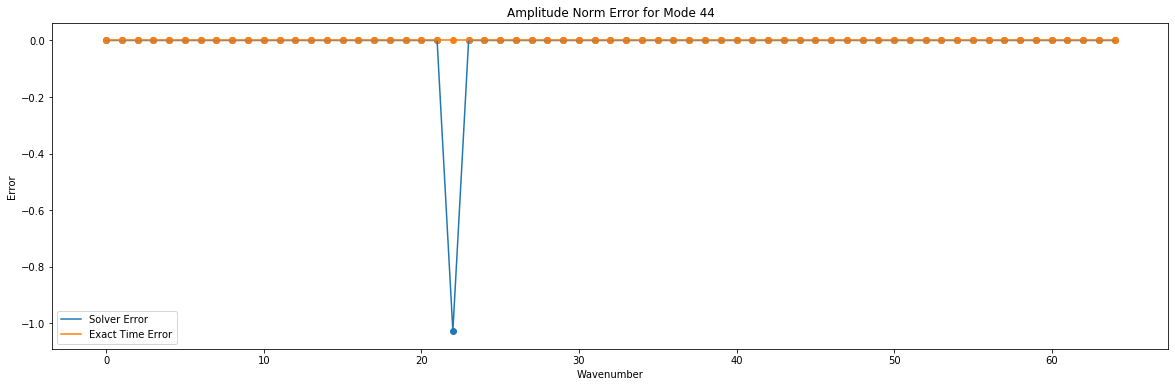

Actual:
[ 0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -2.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e+00 -1.80797859e+00 -2.00000000e-15 -4.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15 -3.00000000e-15  2.00000000e-15  0.00000000e+00  2.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15

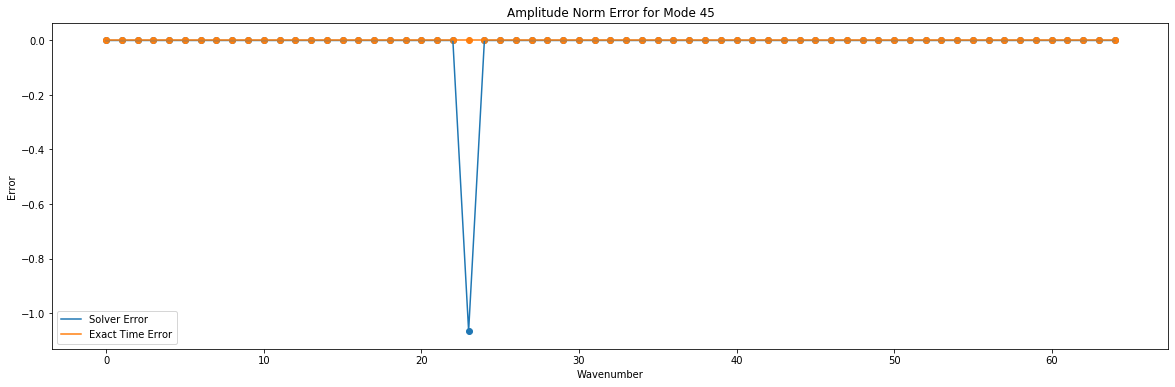

Actual:
[ 0.00000000e+00 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  2.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -1.00000000e-15  1.80797859e+00  1.00000000e+00 -4.00000000e-15  2.00000000e-15 -2.00000000e-15 -0.00000000e+00 -3.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15

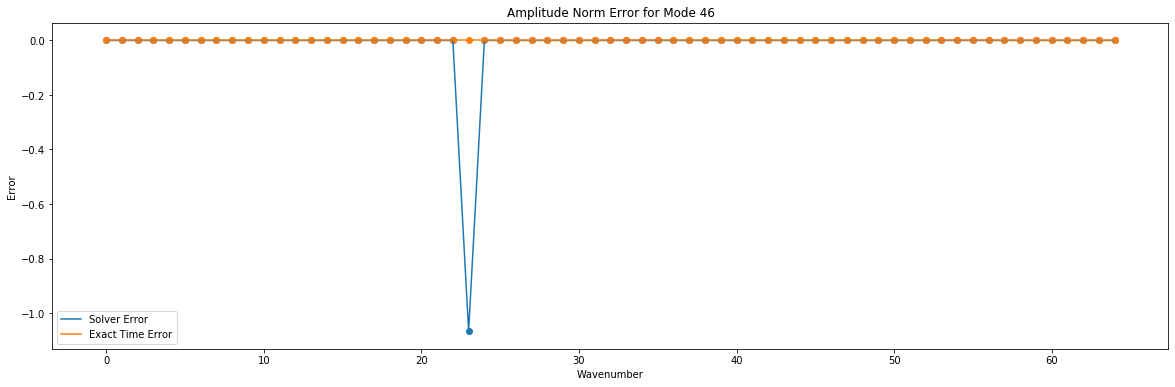

Actual:
[ 0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -2.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  1.00000000e-15  1.00000000e+00 -1.84775907e+00 -2.00000000e-15 -0.00000000e+00 -2.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -4.00000000e-15

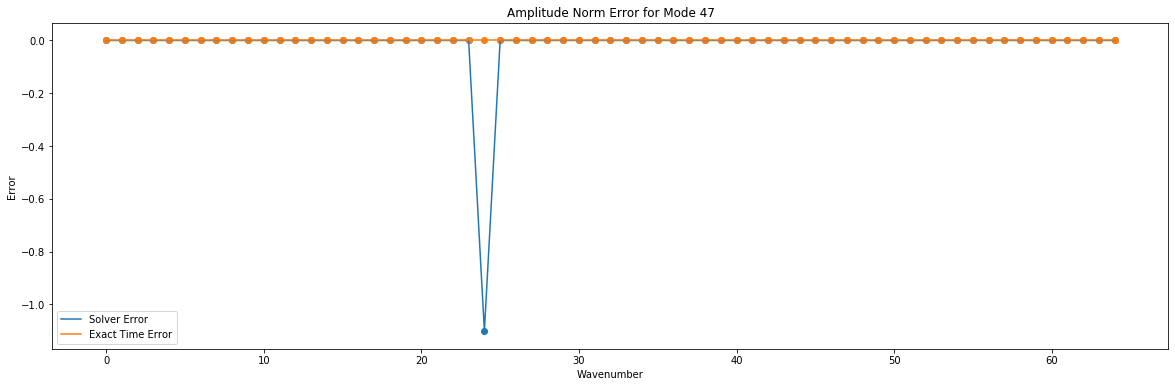

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -2.00000000e-15  2.00000000e-15 -2.00000000e-15  2.00000000e-15 -0.00000000e+00  3.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.84775907e+00  1.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  2.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15

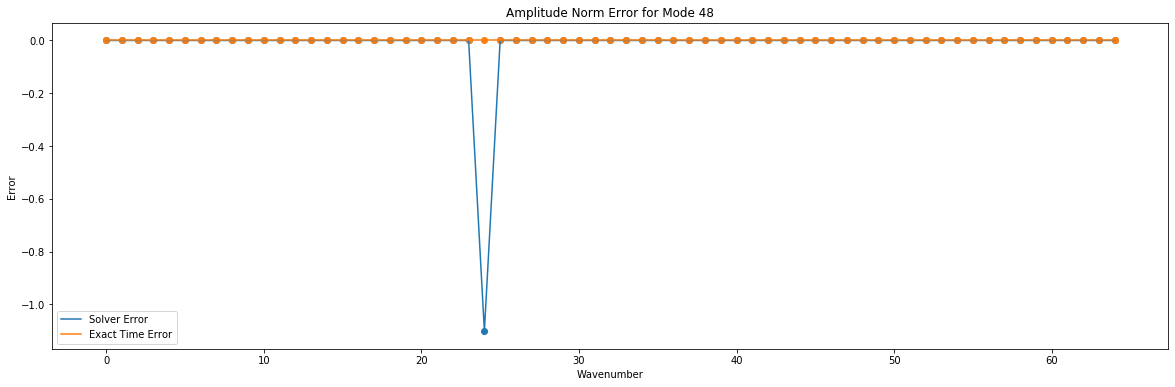

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.00000000e-15  1.00000000e+00 -1.88308813e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15

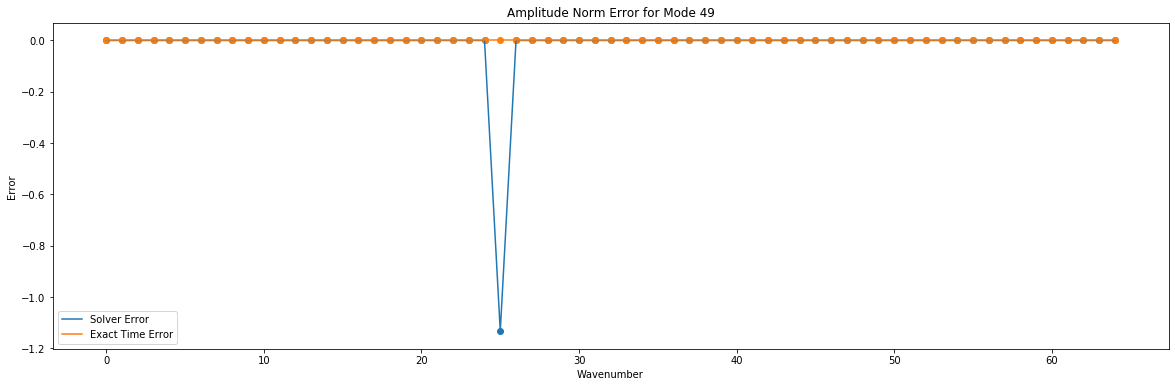

Actual:
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15 -1.00000000e-15  1.88308813e+00  1.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15

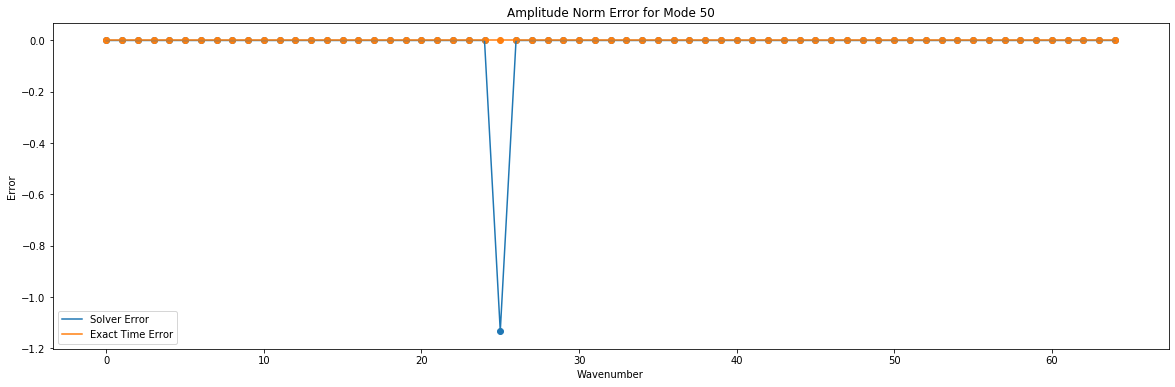

Actual:
[ 0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  2.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e+00 -1.91388067e+00 -1.00000000e-15  1.00000000e-15 -2.00000000e-15 -0.00000000e+00  0.00000000e+00 -4.00000000e-15  0.00000000e+00  2.00000000e-15 -0.00000000e+00

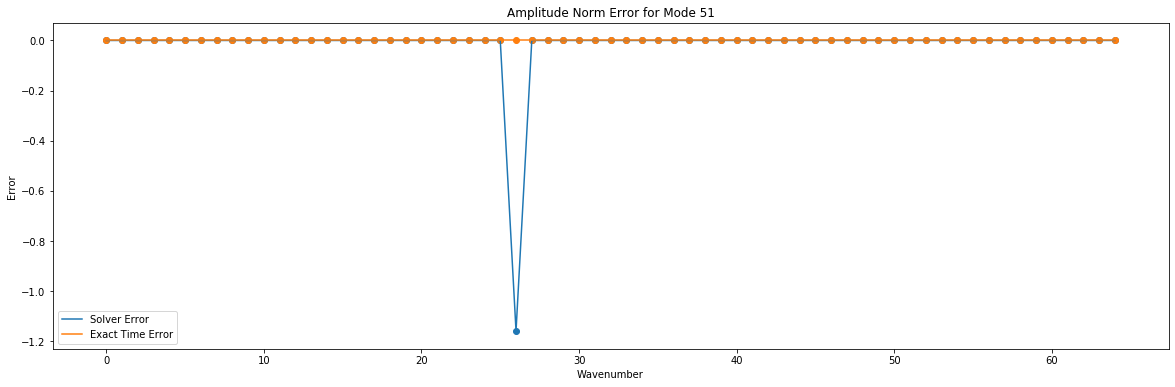

Actual:
[-0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -2.00000000e-15  2.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -2.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.91388067e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e-15 -4.00000000e-15 -0.00000000e+00  2.00000000e-15 -1.00000000e-15 -5.00000000e-15

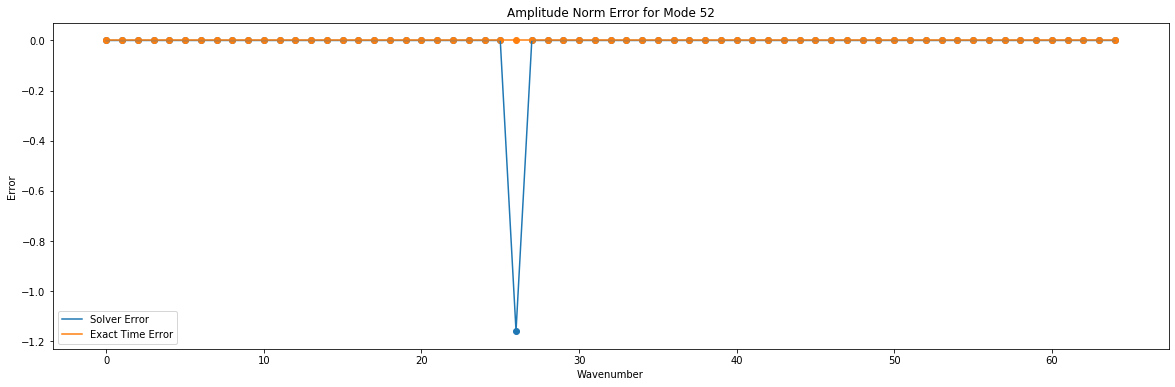

Actual:
[-0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -2.00000000e-15  1.00000000e-15  1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e+00 -1.94006251e+00  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15

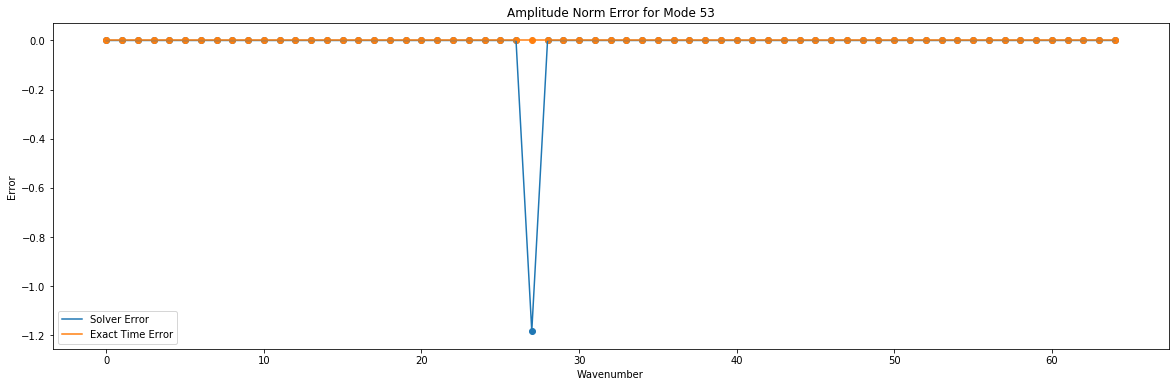

Actual:
[ 0.00000000e+00 -3.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -2.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  2.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.94006251e+00  1.00000000e+00 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00

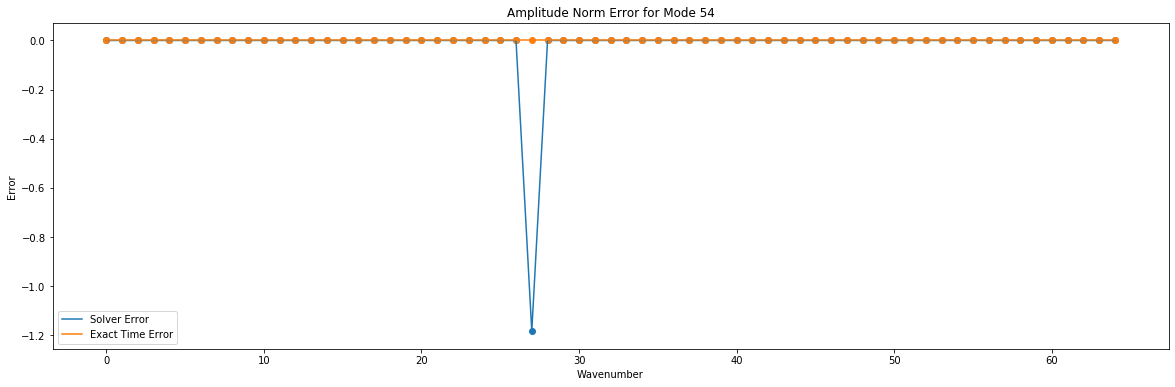

Actual:
[-1.00000000e-15  2.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e+00 -1.96157056e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00

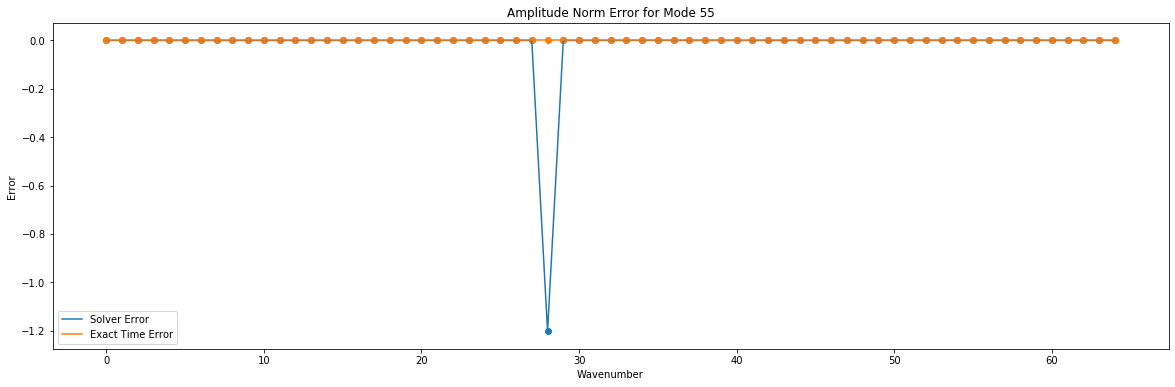

Actual:
[-1.00000000e-15 -2.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.96157056e+00  1.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15

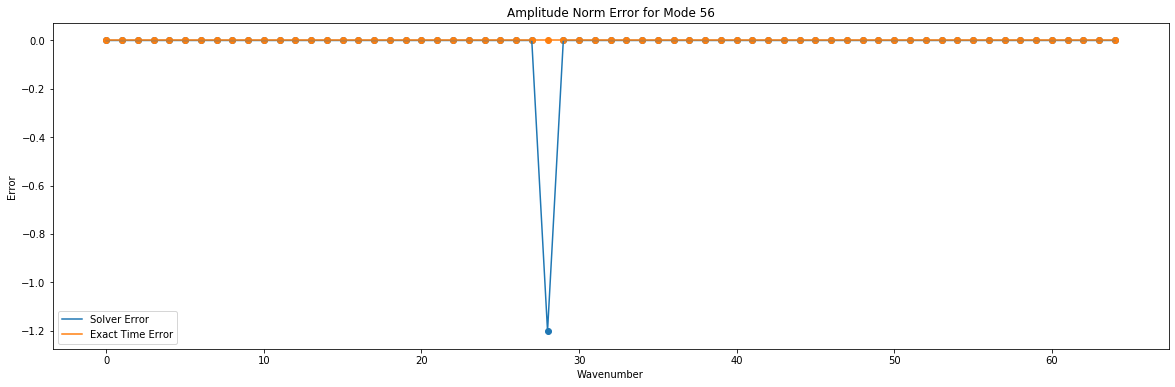

Actual:
[ 0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  2.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  2.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e+00 -1.97835302e+00  0.00000000e+00  3.00000000e-15 -1.00000000e-15

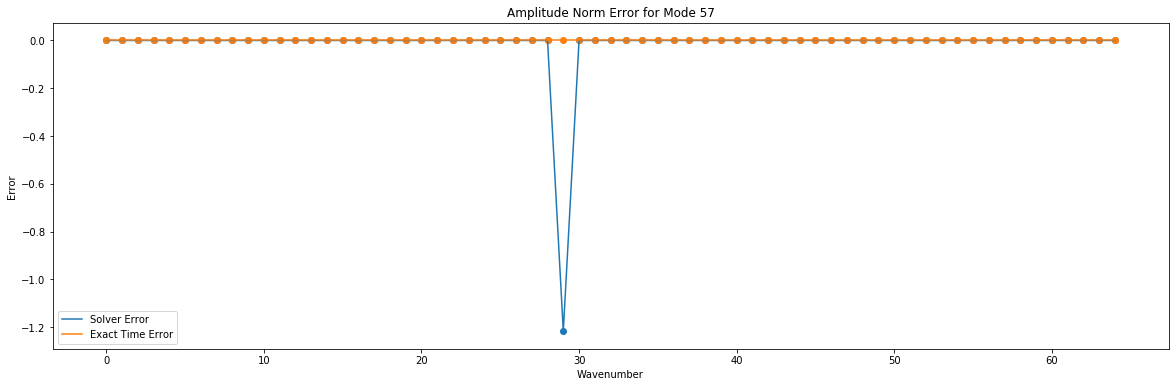

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.97835302e+00  1.00000000e+00  3.00000000e-15 -1.00000000e-15 -1.00000000e-15

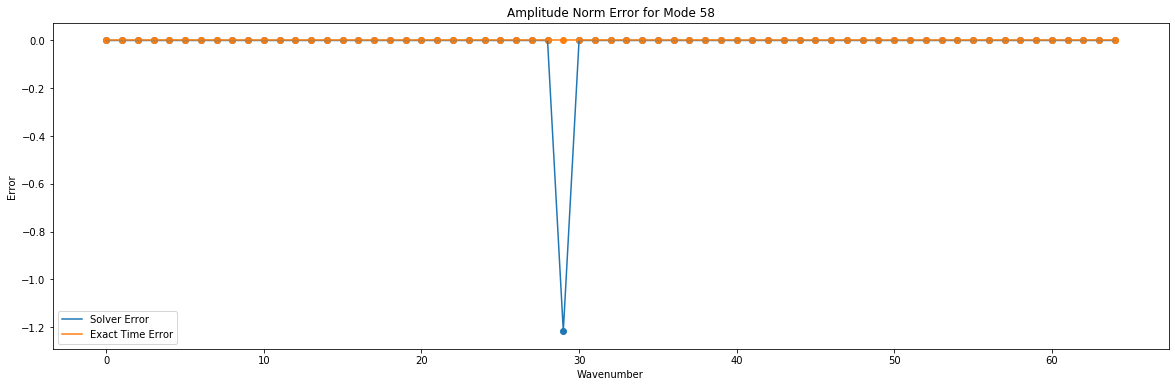

Actual:
[-1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  4.00000000e-15  2.00000000e-15 -1.00000000e-15  5.00000000e-15 -4.00000000e-15  2.00000000e-15  1.00000000e+00 -1.99036945e+00 -1.00000000e-15

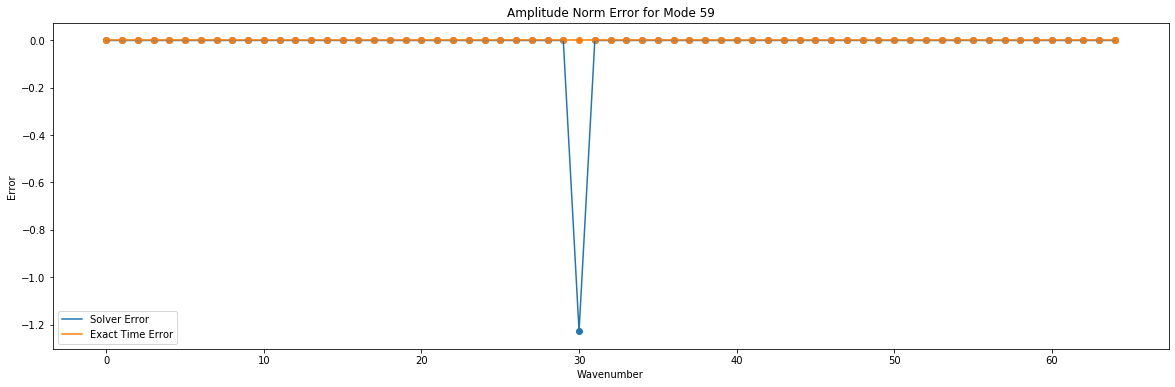

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -2.00000000e-15  1.00000000e-15 -3.00000000e-15  5.00000000e-15  1.00000000e-15  2.00000000e-15  4.00000000e-15  1.99036945e+00  1.00000000e+00  1.00000000e-15

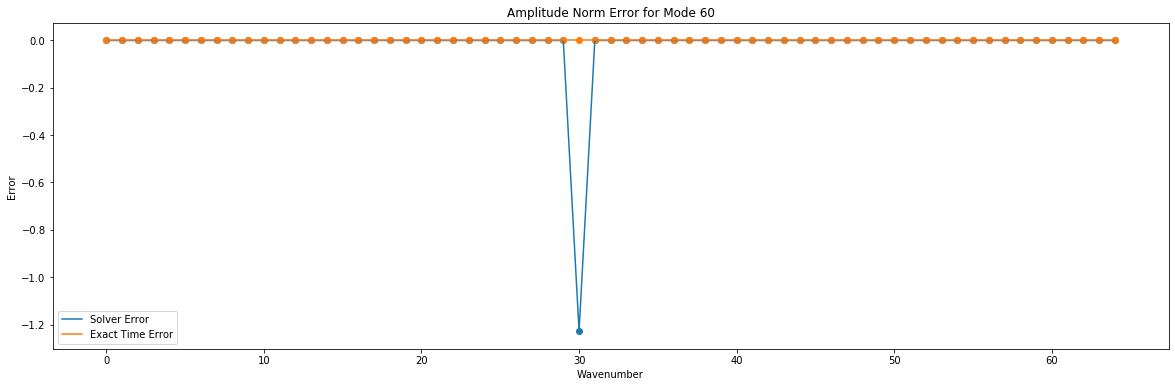

Actual:
[-0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -2.00000000e-15 -2.00000000e-15  0.00000000e+00 -3.00000000e-15  3.00000000e-15 -2.00000000e-15  2.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e+00

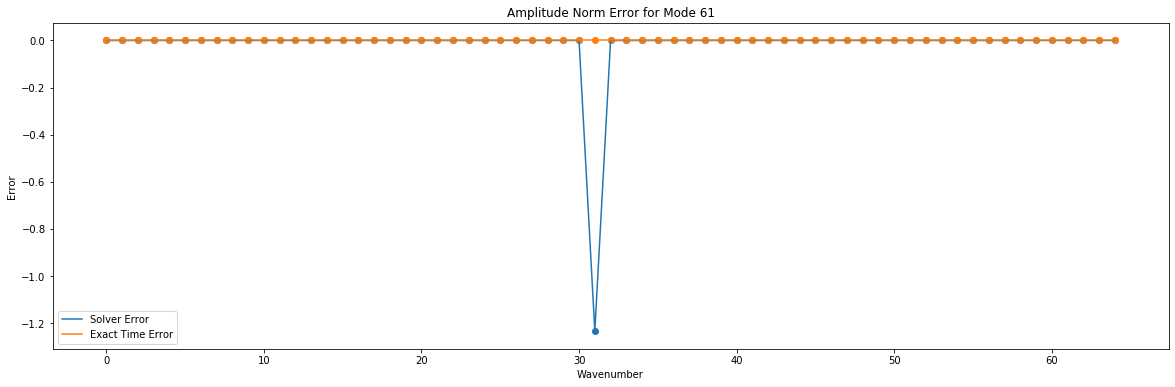

Actual:
[-0.00000000e+00 -2.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -2.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -4.00000000e-15 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -2.00000000e-15  2.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.99759091e+00

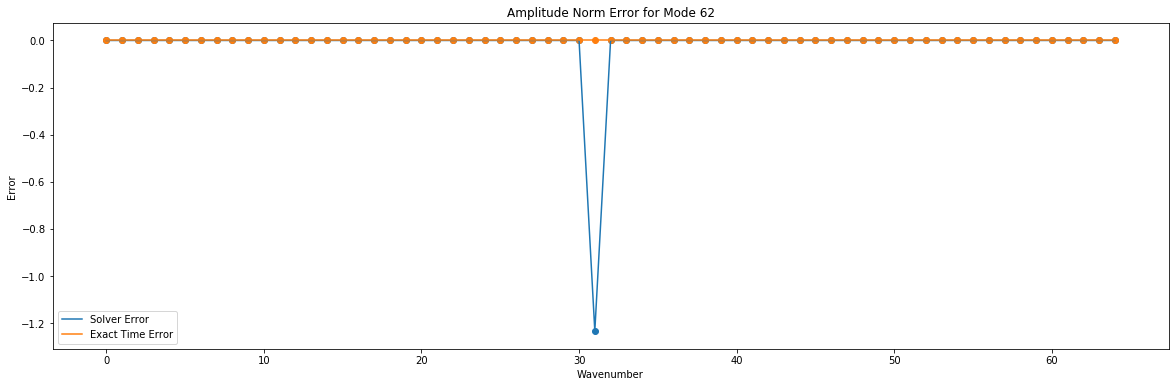

Actual:
[-1.e-15 -0.e+00  0.e+00 -1.e-15  1.e-15  0.e+00 -1.e-15  1.e-15 -0.e+00 -1.e-15  0.e+00 -0.e+00  0.e+00  1.e-15 -0.e+00 -1.e-15  1.e-15 -0.e+00 -0.e+00 -0.e+00 -1.e-15 -0.e+00 -1.e-15  0.e+00 -1.e-15  1.e-15  0.e+00 -0.e+00 -1.e-15  2.e-15  0.e+00  1.e-15 -1.e-15 -1.e-15  0.e+00  1.e-15 -1.e-15  1.e-15  1.e-15  0.e+00  1.e-15 -0.e+00  0.e+00  0.e+00 -1.e-15  0.e+00  2.e-15  1.e-15  1.e-15 -2.e-15  1.e-15 -1.e-15 -1.e-15 -1.e-15  0.e+00 -0.e+00 -1.e-15  1.e-15 -2.e-15 -1.e-15  2.e-15 -1.e-15 -1.e-15  1.e+00 -2.e+00 -1.e-15  1.e-15 -0.e+00 -1.e-15  1.e-15  1.e-15 -1.e-15  1.e-15 -0.e+00 -0.e+00 -0.e+00  1.e-15 -3.e-15 -2.e-15 -0.e+00 -1.e-15  1.e-15 -2.e-15 -1.e-15  1.e-15 -1.e-15  0.e+00 -0.e+00 -2.e-15  1.e-15 -1.e-15  1.e-15  2.e-15 -4.e-15 -4.e-15  0.e+00  0.e+00  5.e-15 -3.e-15  1.e-15  1.e-15  1.e-15 -0.e+00  1.e-15  3.e-15 -1.e-15  1.e-15 -1.e-15 -2.e-15 -1.e-15  1.e-15 -1.e-15 -5.e-15  3.e-15 -0.e+00  1.e-15  1.e-15 -1.e-15 -1.e-15  2.e-15 -2.e-15  2.e-15 -0.e+00  1.e-15

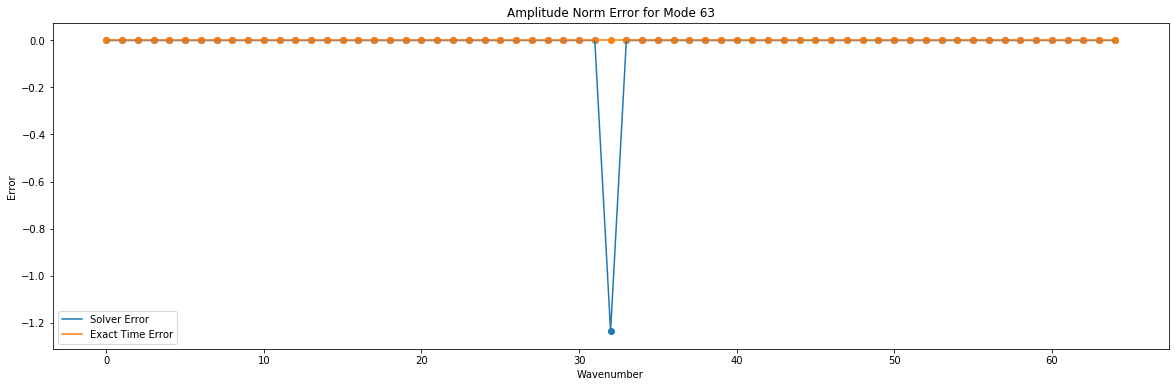

Actual:
[-1.e-15 -1.e-15 -1.e-15 -1.e-15  0.e+00 -1.e-15  0.e+00 -1.e-15  1.e-15  1.e-15  1.e-15 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  1.e-15 -2.e-15 -1.e-15  1.e-15  1.e-15  0.e+00 -0.e+00 -0.e+00 -1.e-15 -0.e+00  0.e+00  0.e+00 -0.e+00  1.e-15 -2.e-15  0.e+00 -0.e+00  1.e-15  1.e-15 -1.e-15 -1.e-15  1.e-15 -0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -1.e-15  0.e+00  1.e-15 -1.e-15  1.e-15 -0.e+00  2.e-15  2.e-15 -1.e-15  1.e-15 -0.e+00  1.e-15 -1.e-15  0.e+00 -1.e-15 -1.e-15  1.e-15 -0.e+00 -0.e+00  1.e-15  2.e+00  1.e+00  0.e+00  0.e+00 -1.e-15 -0.e+00  1.e-15 -1.e-15  1.e-15  1.e-15  0.e+00  1.e-15  1.e-15  1.e-15 -2.e-15  2.e-15 -2.e-15 -0.e+00 -1.e-15 -1.e-15  1.e-15  0.e+00 -0.e+00  1.e-15 -2.e-15  0.e+00 -0.e+00 -1.e-15  2.e-15 -0.e+00 -4.e-15  4.e-15 -1.e-15 -0.e+00 -5.e-15 -5.e-15  2.e-15 -2.e-15 -1.e-15 -1.e-15  1.e-15 -2.e-15  1.e-15  1.e-15 -3.e-15 -1.e-15  2.e-15 -4.e-15  3.e-15  0.e+00  1.e-15  3.e-15 -0.e+00  1.e-15  0.e+00  0.e+00 -1.e-15  0.e+00 -0.e+00 -0.e+00  1.e-15

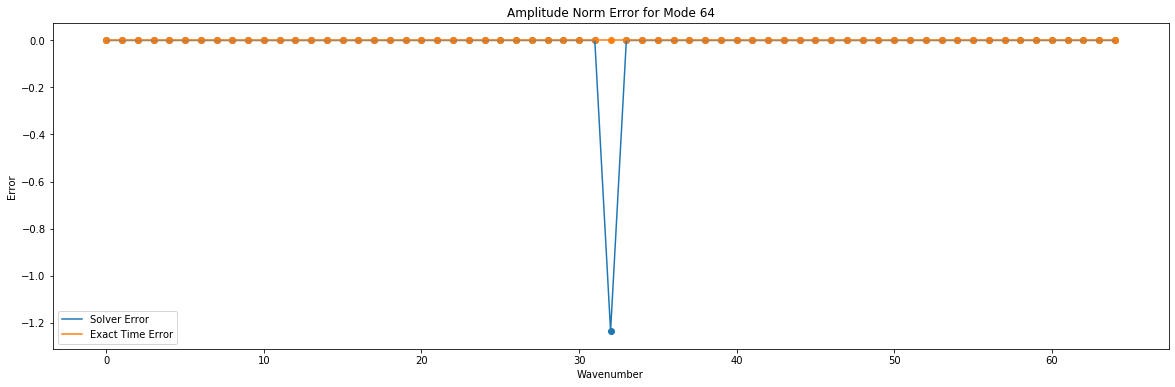

Actual:
[-1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00

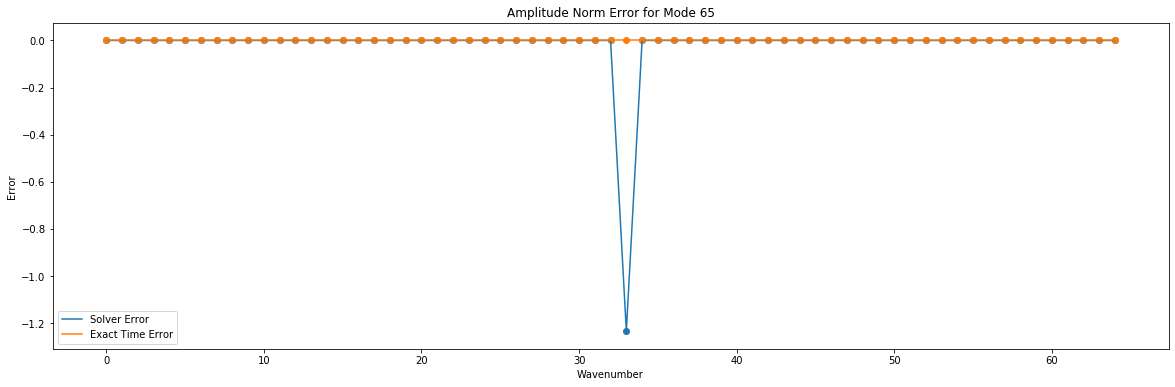

Actual:
[-1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -2.00000000e-15  2.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15

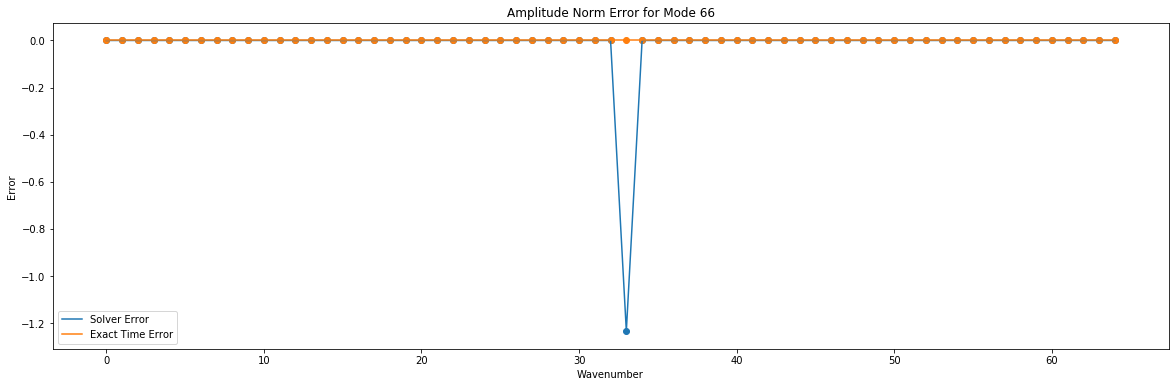

Actual:
[-0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -2.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  2.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  2.00000000e-15

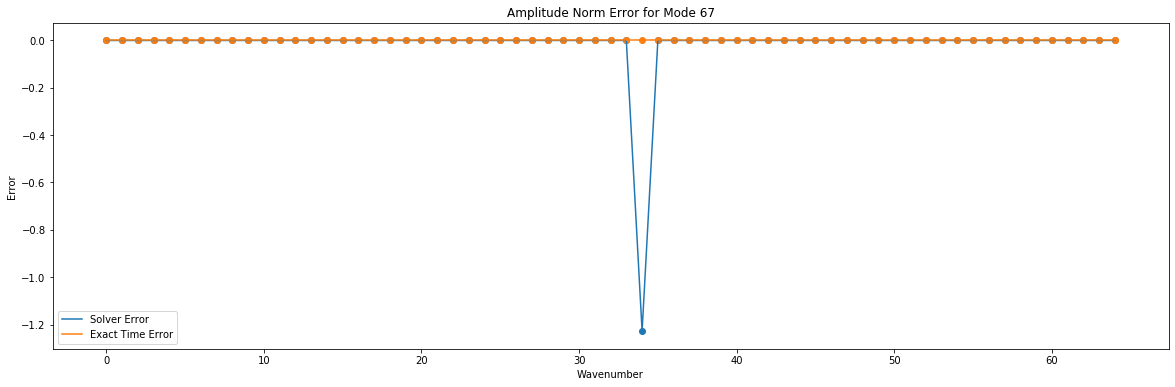

Actual:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  2.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00

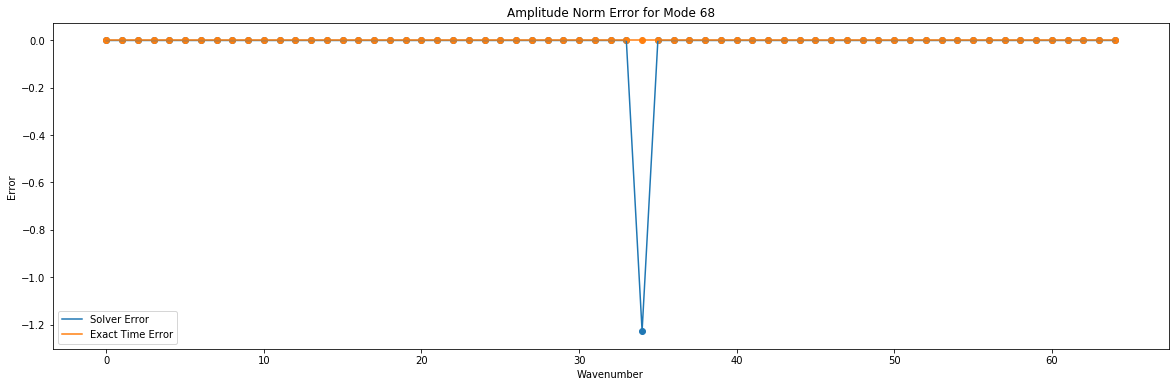

Actual:
[-1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15

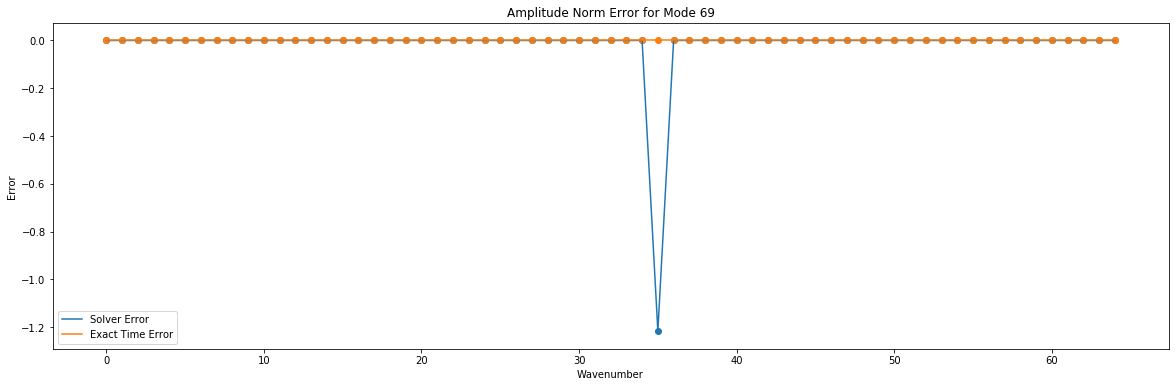

Actual:
[-0.00000000e+00 -2.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -2.00000000e-15  2.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15

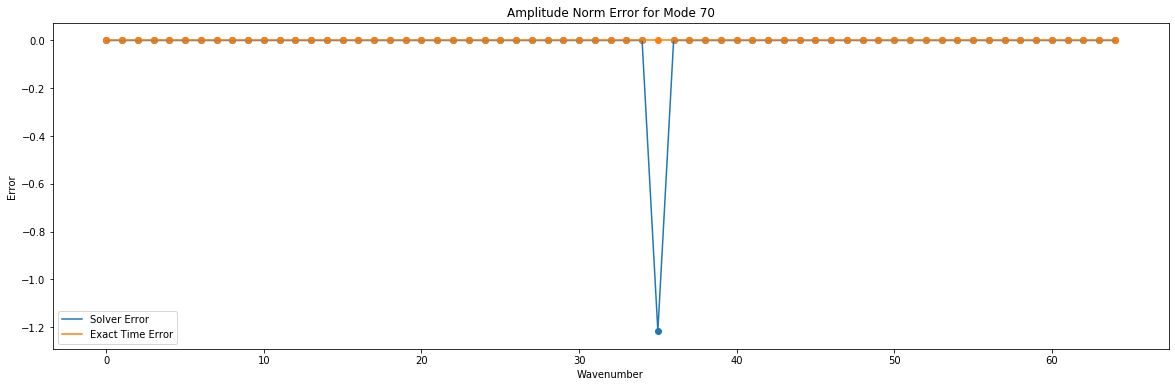

Actual:
[-0.00000000e+00  2.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -2.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -3.00000000e-15 -0.00000000e+00 -0.00000000e+00 -5.00000000e-15  4.00000000e-15 -1.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15

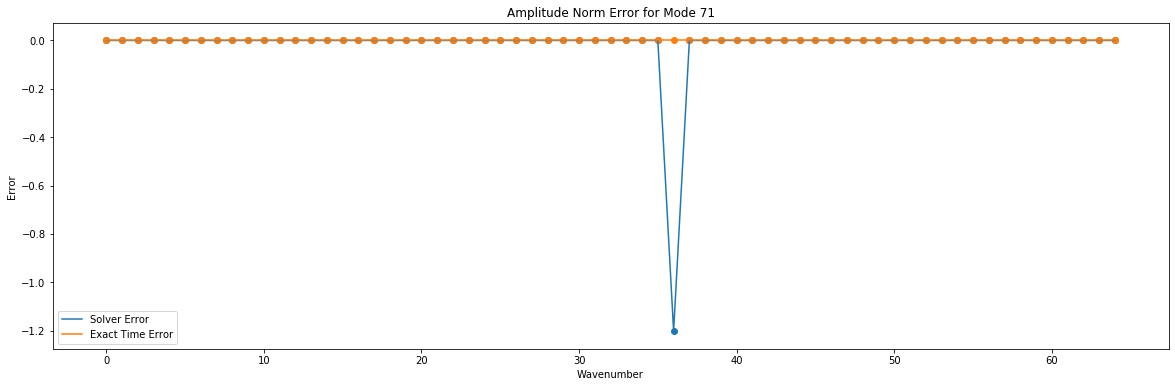

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -2.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  3.00000000e-15 -4.00000000e-15 -0.00000000e+00 -2.00000000e-15 -4.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -2.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15

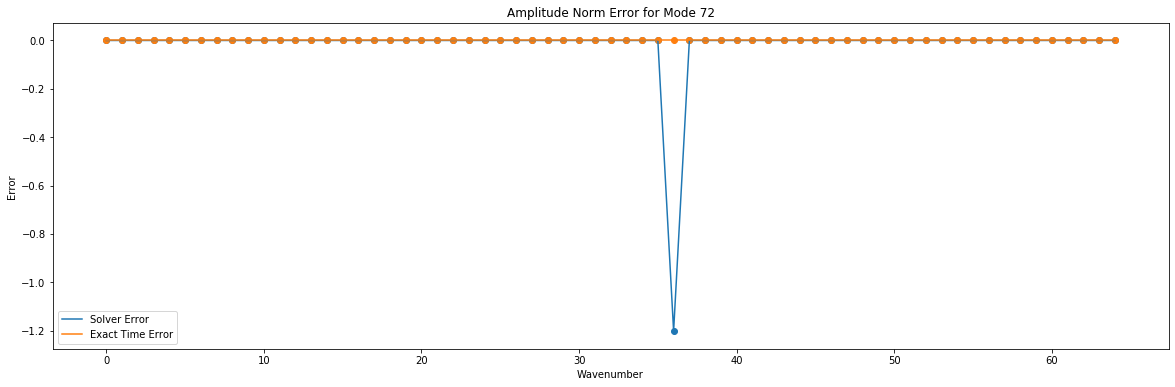

Actual:
[-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15

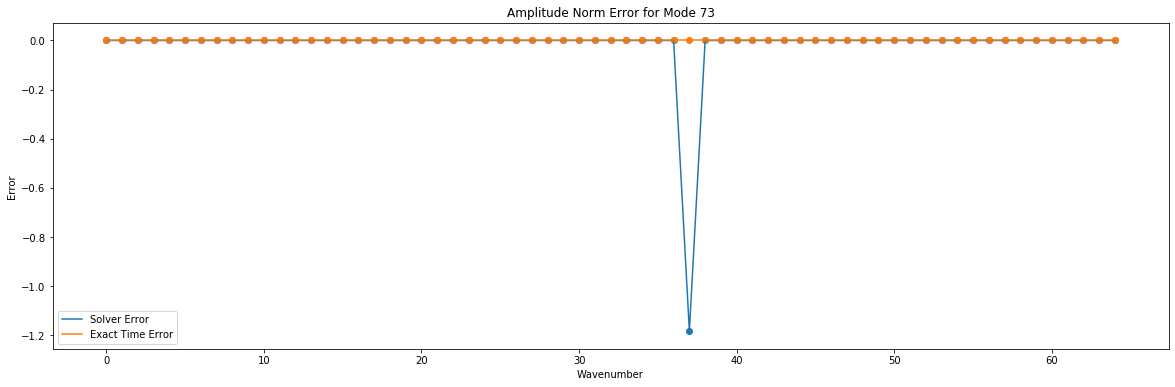

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -3.00000000e-15

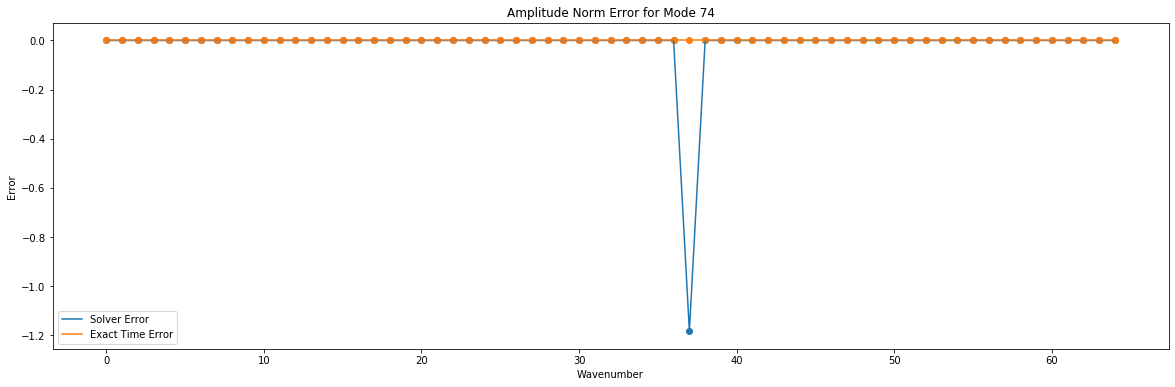

Actual:
[-1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15

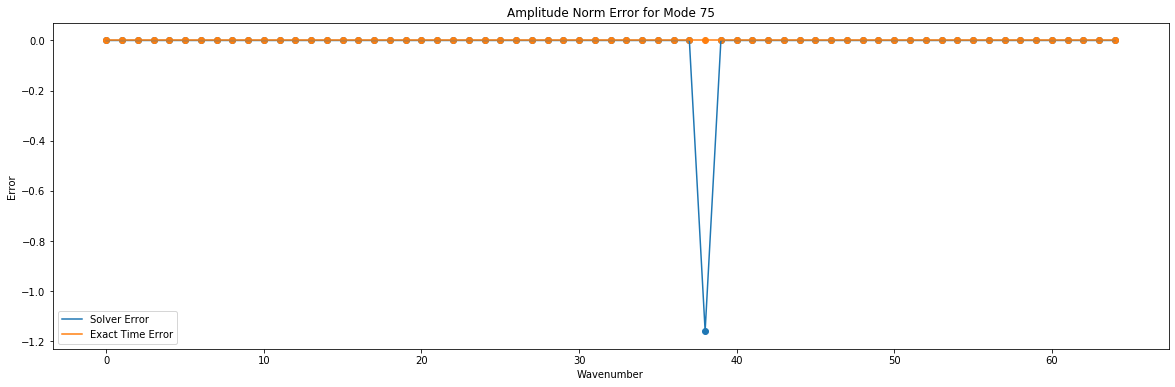

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -2.00000000e-15

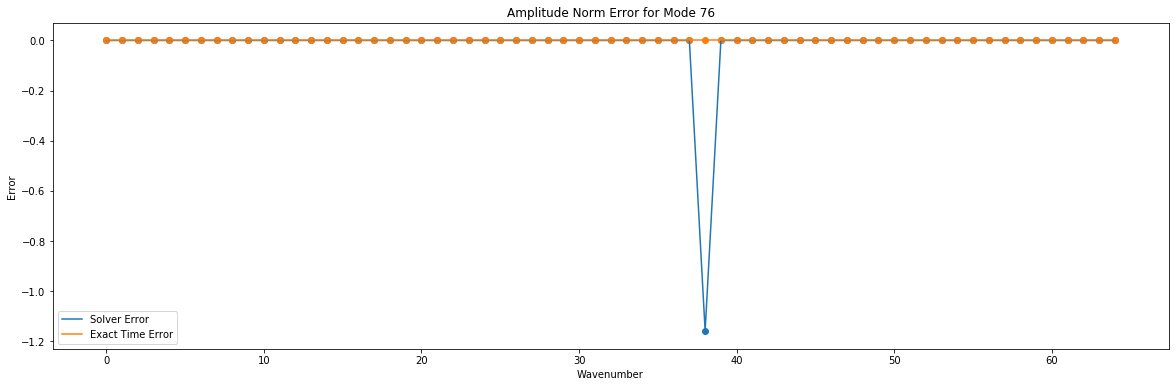

Actual:
[-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15

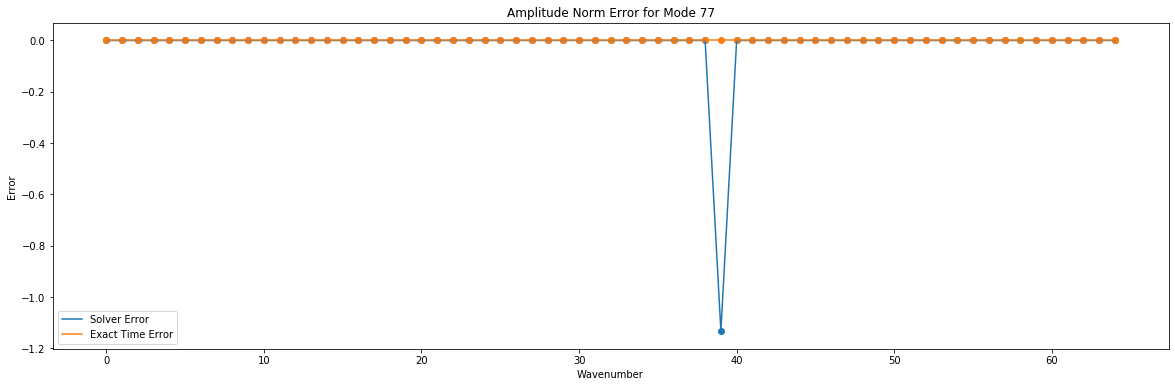

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00

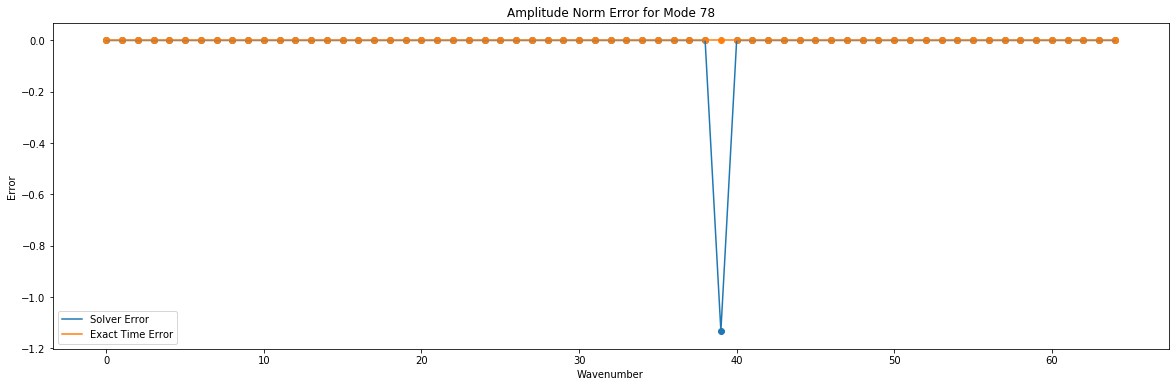

Actual:
[-1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -3.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -2.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -3.00000000e-15 -2.00000000e-15 -0.00000000e+00 -2.00000000e-15  2.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15

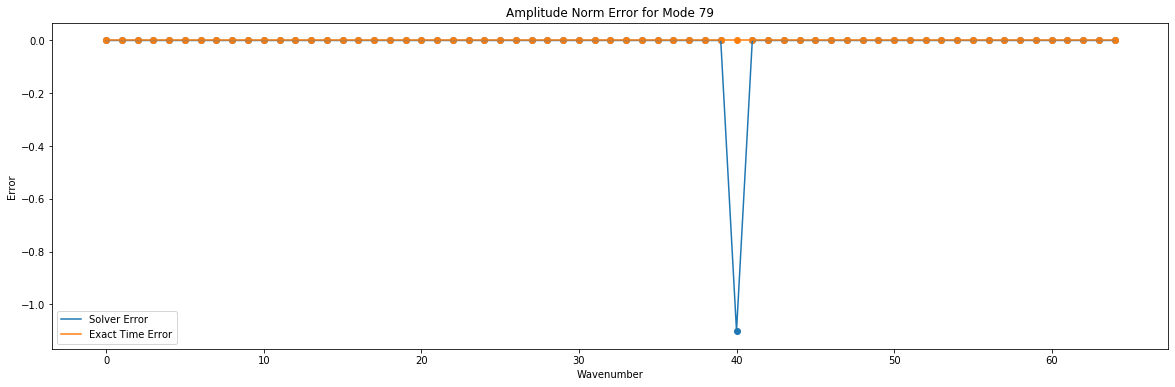

Actual:
[-1.00000000e-15 -2.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15  2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -2.00000000e-15  3.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15

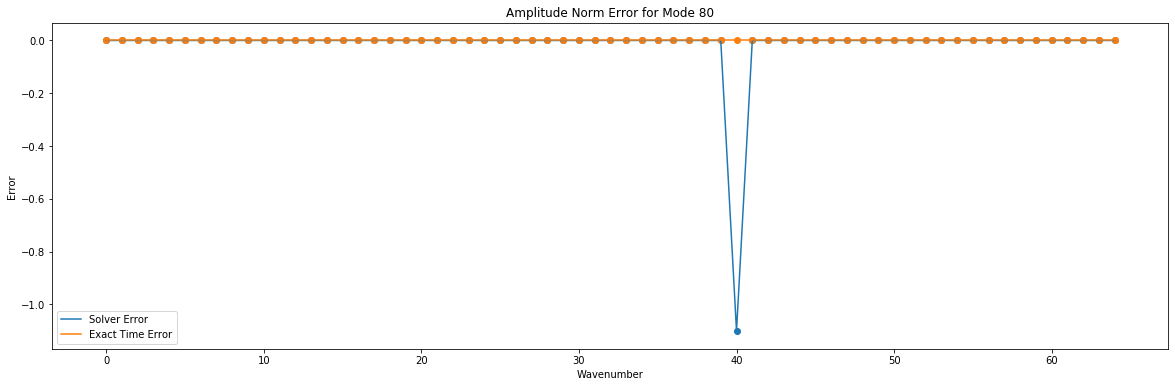

Actual:
[-0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  2.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -3.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -3.00000000e-15  0.00000000e+00 -0.00000000e+00 -7.00000000e-15  3.00000000e-15 -1.00000000e-15  0.00000000e+00

[ 0.          0.         -0.          0.          0.         -0.         -0.         -0.         -0.         -0.         -0.         -0.         -0.          0.          0.          0.          0.         -0.          0.          0.         -0.          0.          0.         -0.         -0.          0.          0.          0.          0.         -0.          0.         -0.          0.         -0.         -0.          0.          0.         -0.          0.         -0.         -0.         -0.         -0.         -0.         -0.         -0.          0.          0.          0.         -0.          0.         -0.         -0.         -0.          0.          0.          0.         -0.          0.          0.          0.         -0.         -0.          0.         -0.          0.          0.          0.         -0.          0.          0.         -0.         -0.         -0.         -0.          0.         -0.         -0.          0.          0.          0.          0.53499762 -0.84485357 -0.

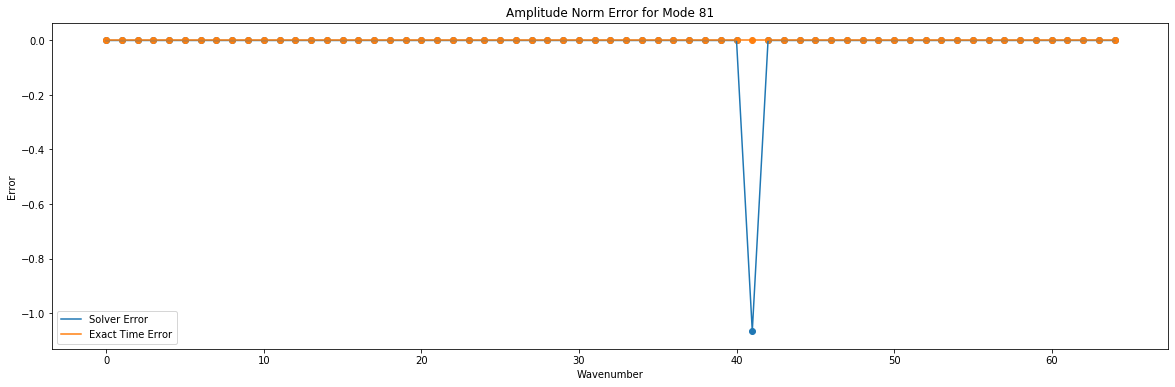

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -2.00000000e-15  3.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  2.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  3.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  3.00000000e-15 -7.00000000e-15 -0.00000000e+00 -1.00000000e-15 -4.00000000e-15  0.00000000e+00

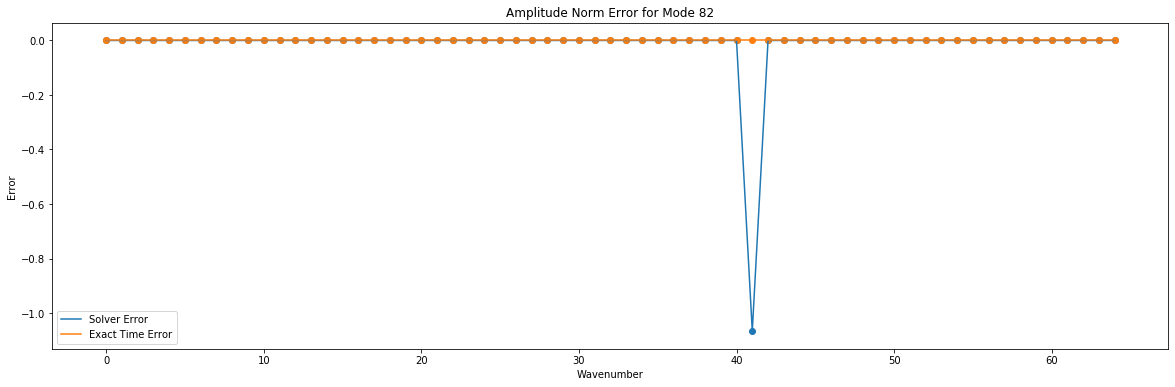

Actual:
[-0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -2.00000000e-15

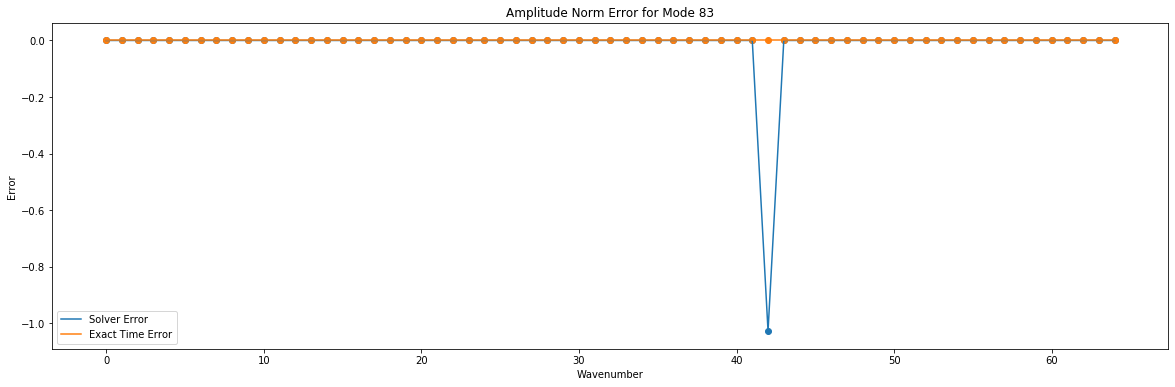

Actual:
[ 0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -1.00000000e-15

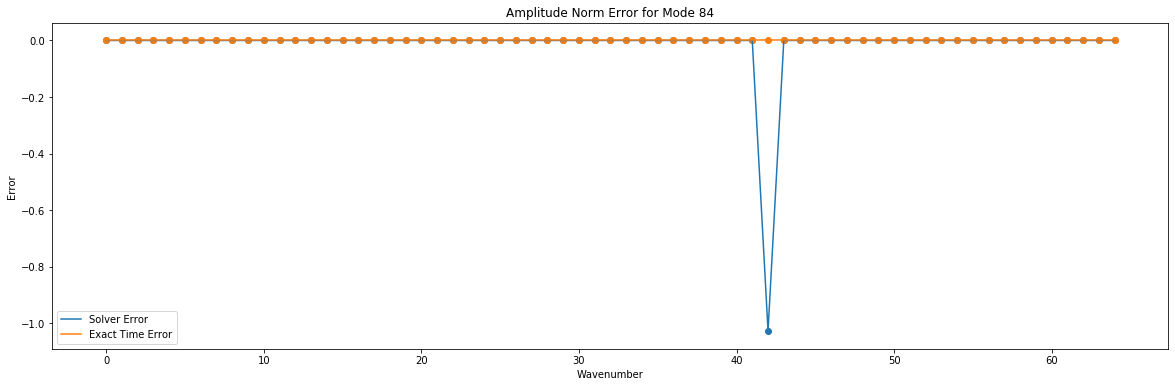

Actual:
[-1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15 -2.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15

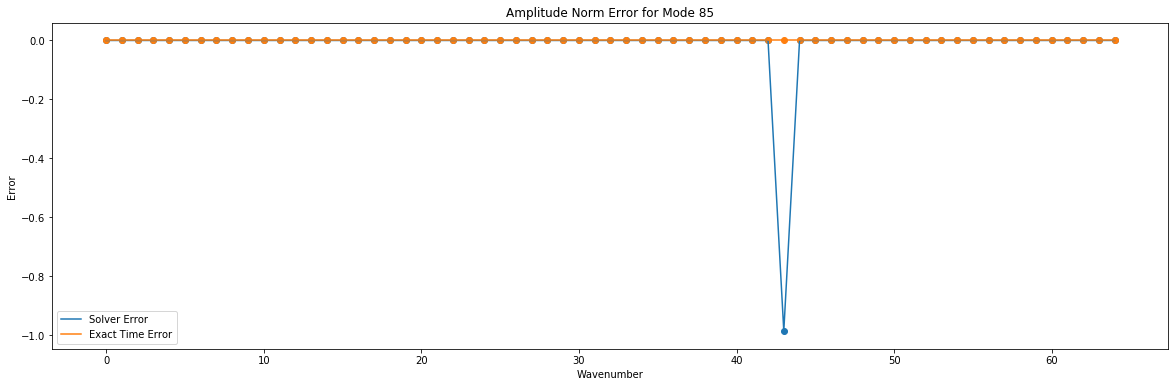

Actual:
[-0.00000000e+00 -2.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  3.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15

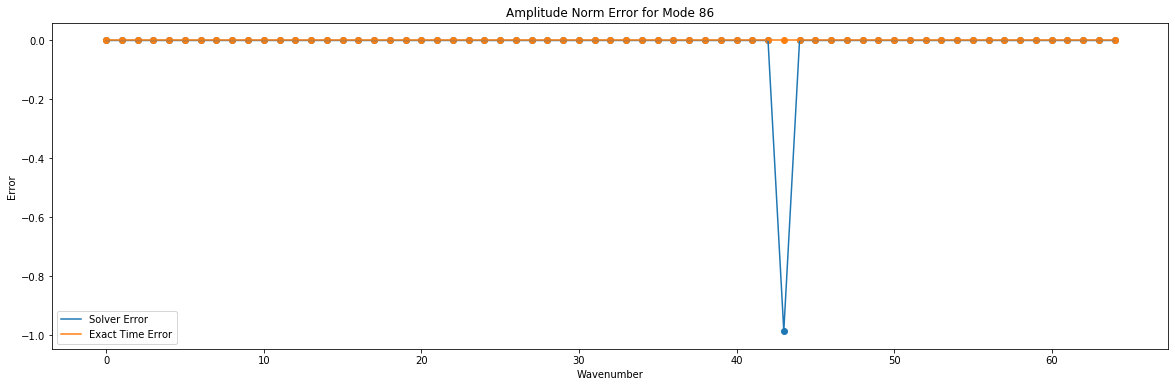

Actual:
[-0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15

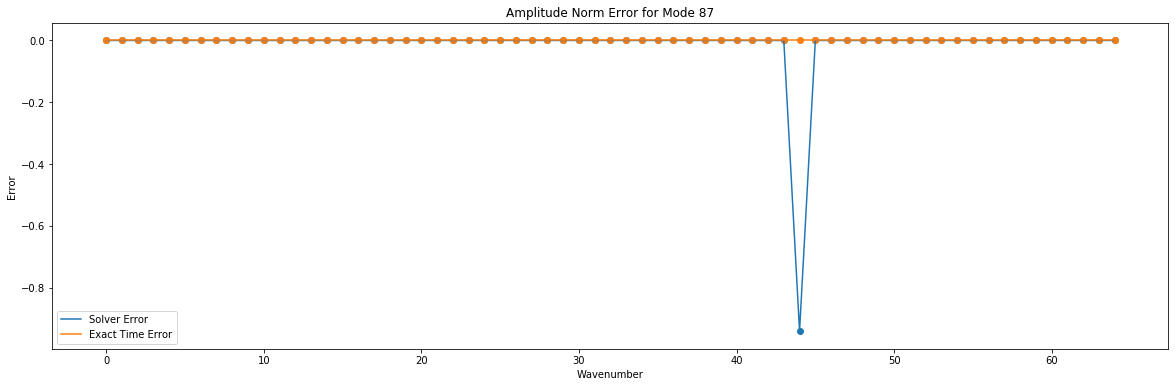

Actual:
[-0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15

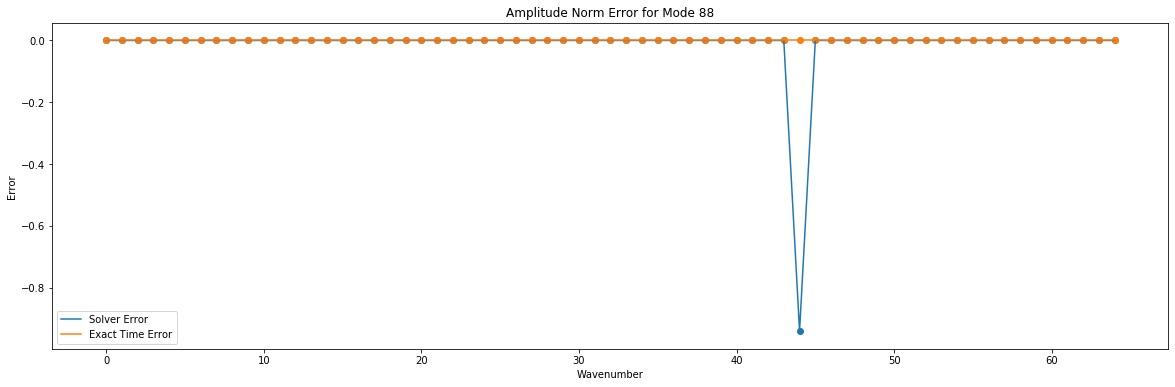

Actual:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15  0.00000000e+00  2.00000000e-15  1.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15

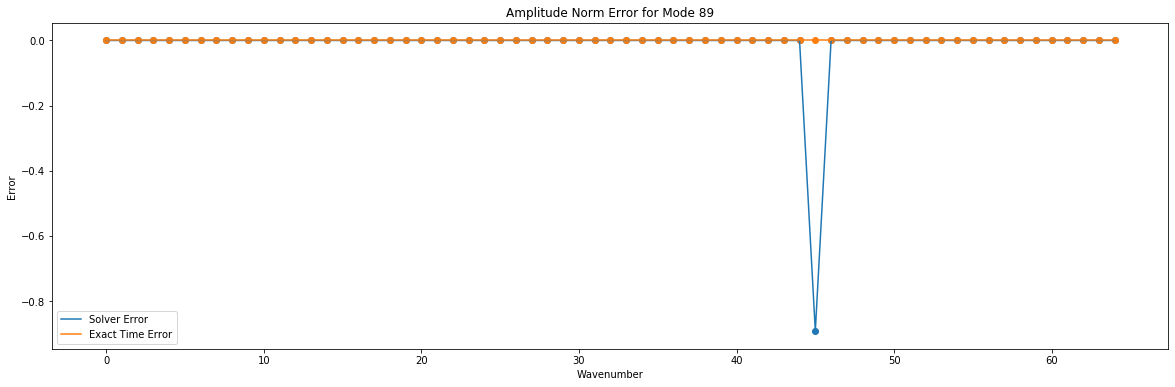

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -3.00000000e-15  0.00000000e+00 -2.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  2.00000000e-15 -1.00000000e-15  2.00000000e-15 -1.00000000e-15  2.00000000e-15

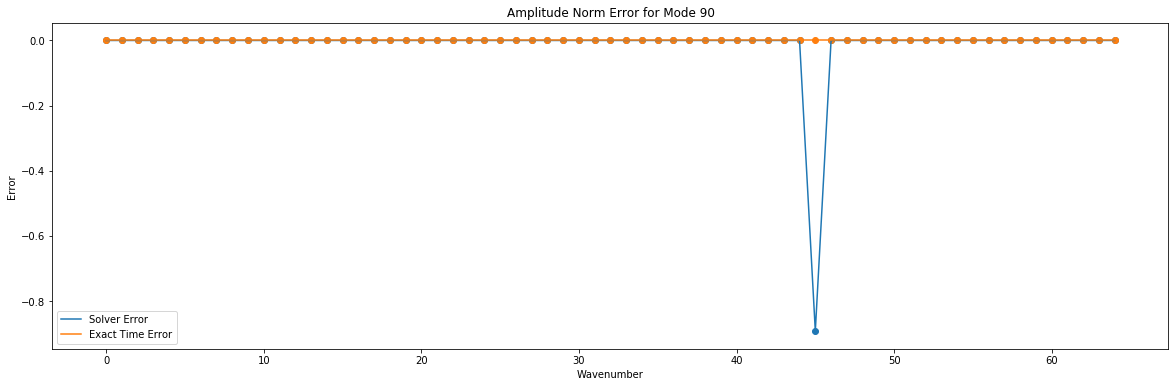

Actual:
[ 0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  3.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  2.00000000e-15

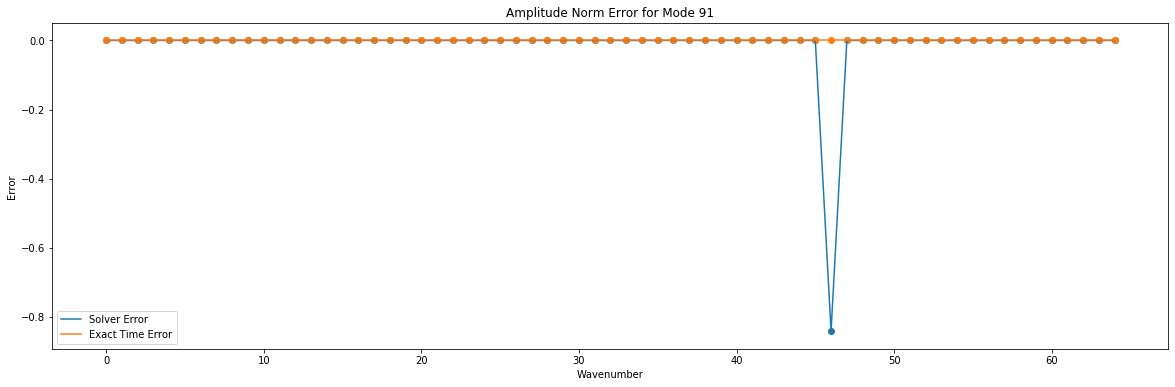

Actual:
[ 0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -2.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -2.00000000e-15 -1.00000000e-15 -1.00000000e-15

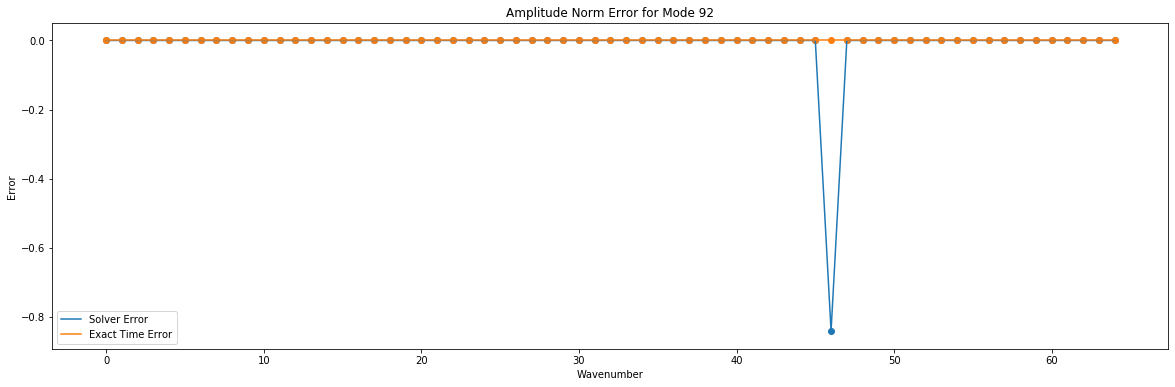

Actual:
[-0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  1.00000000e-15  3.00000000e-15 -1.00000000e-15 -2.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15

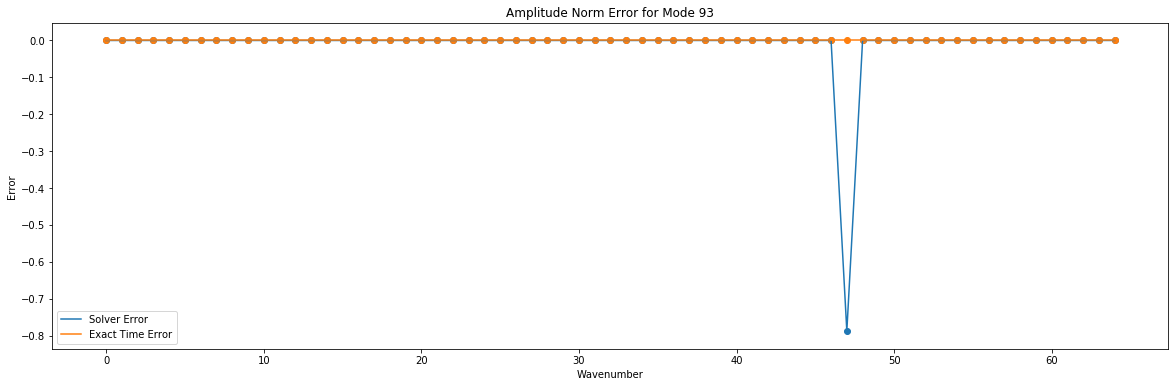

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -3.00000000e-15 -1.00000000e-15  3.00000000e-15 -1.00000000e-15 -2.00000000e-15  2.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00

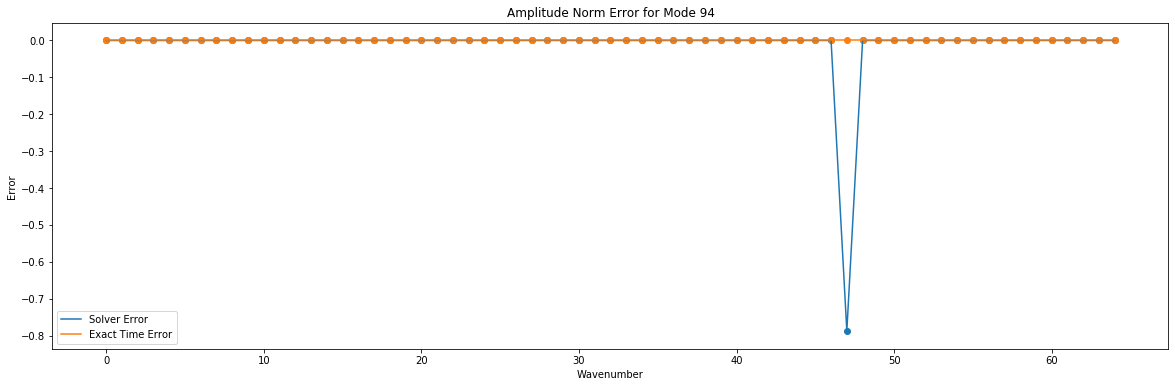

Actual:
[ 0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15

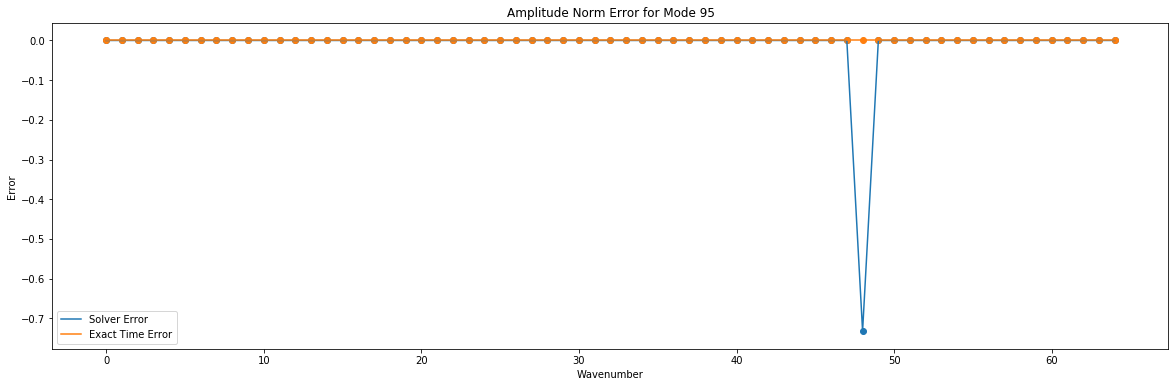

Actual:
[-1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  3.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00  2.00000000e-15 -0.00000000e+00

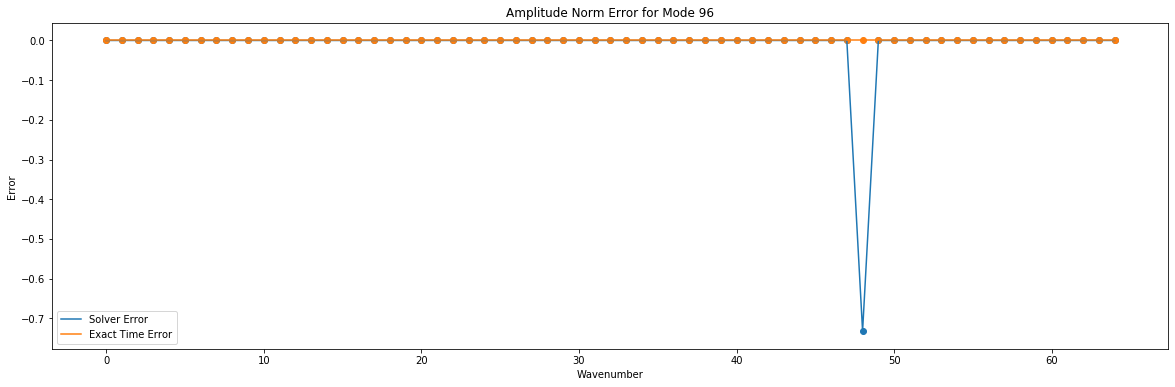

Actual:
[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00

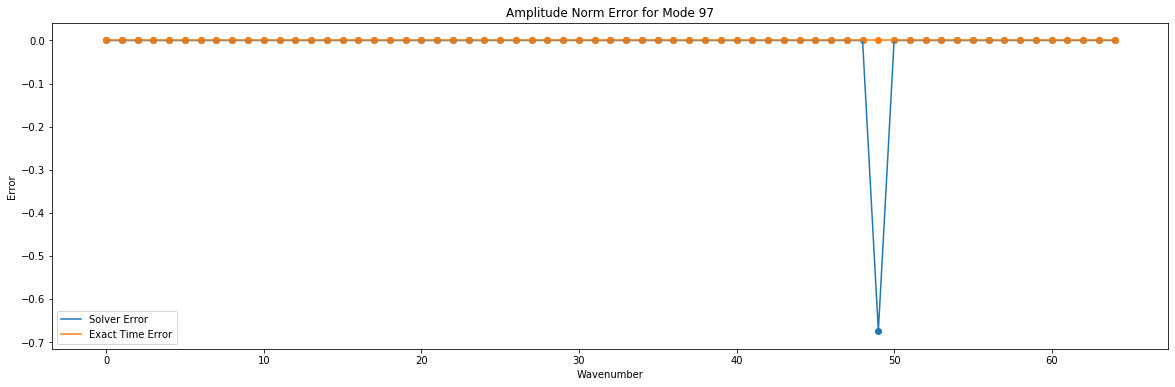

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -2.00000000e-15

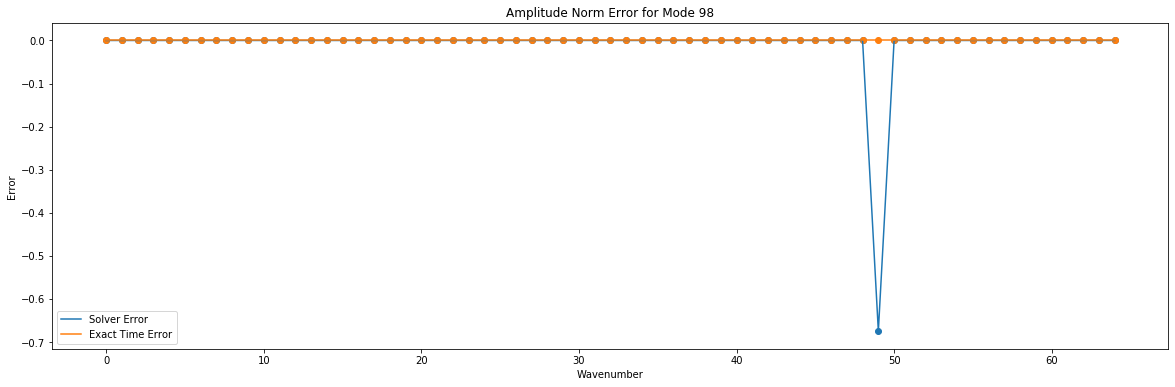

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  2.00000000e-15  0.00000000e+00  1.00000000e-15  2.00000000e-15  0.00000000e+00  2.00000000e-15 -1.00000000e-15  2.00000000e-15 -2.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15

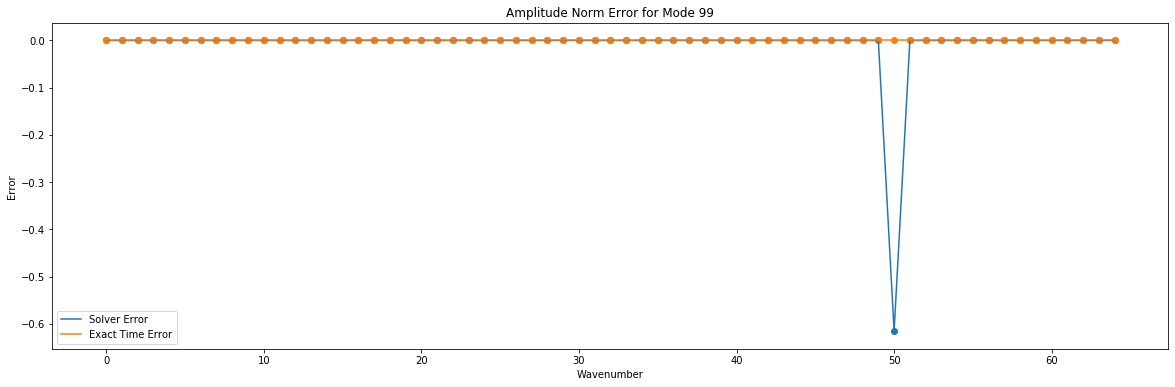

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  2.00000000e-15  1.00000000e-15 -0.00000000e+00  2.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15

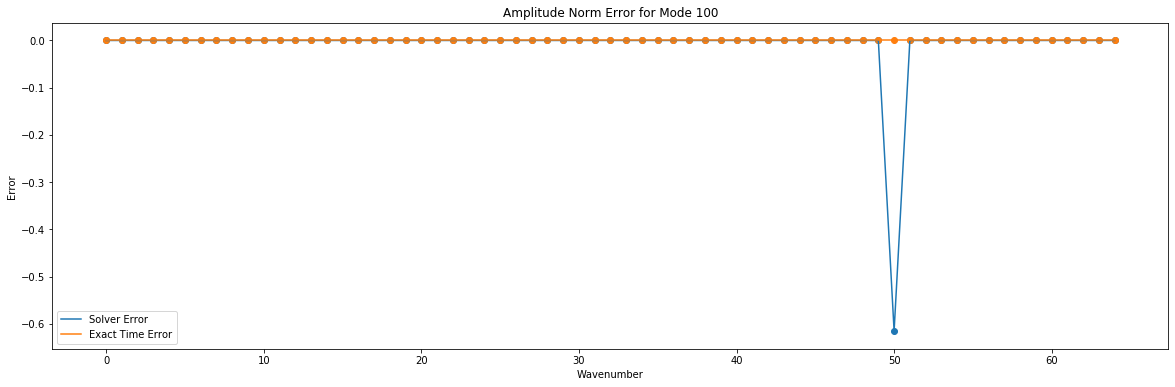

Actual:
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15

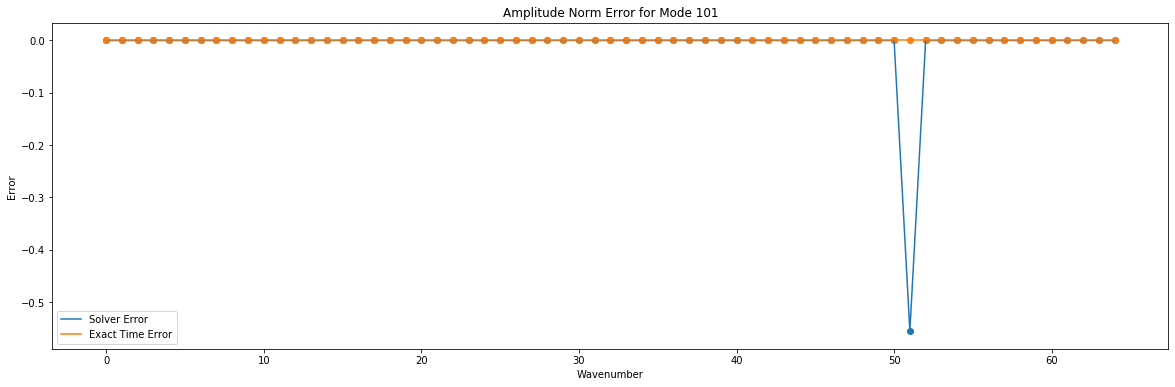

Actual:
[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00

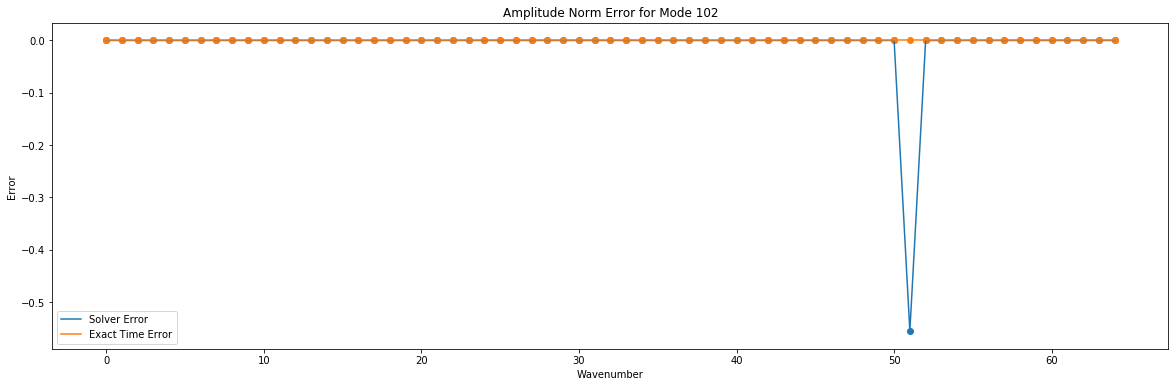

Actual:
[-0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  2.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  2.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00

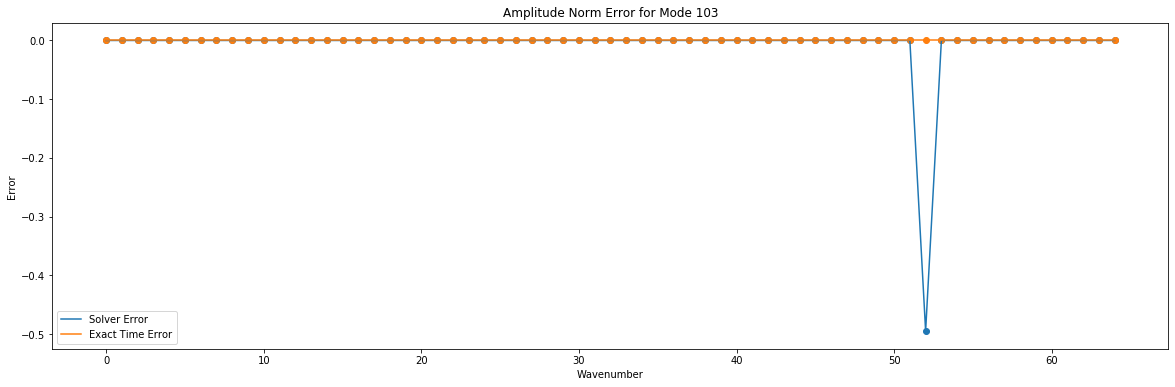

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  2.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  2.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00

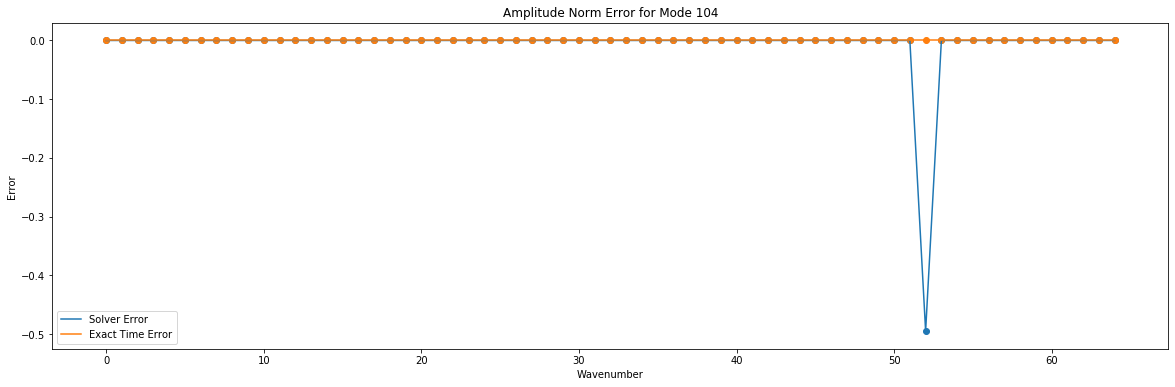

Actual:
[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -3.00000000e-15  0.00000000e+00  2.00000000e-15 -0.00000000e+00 -3.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15

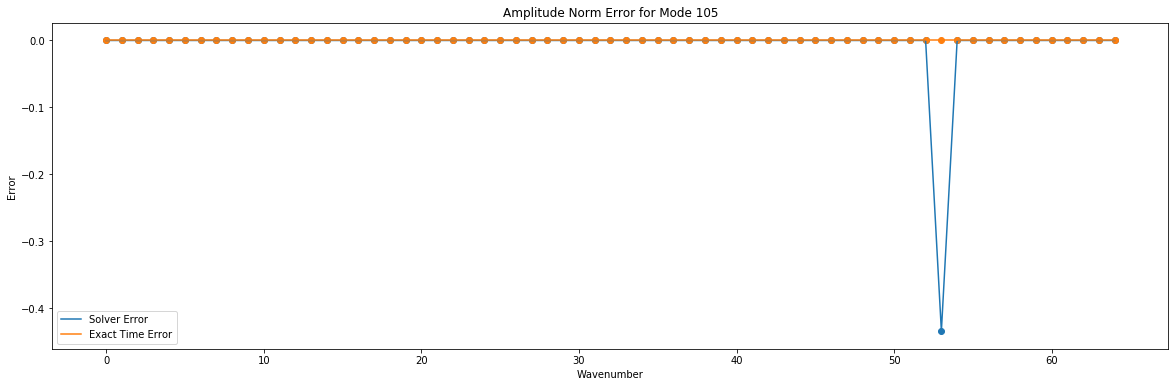

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -3.00000000e-15  1.00000000e-15  2.00000000e-15  1.00000000e-15 -4.00000000e-15 -0.00000000e+00 -0.00000000e+00 -2.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15

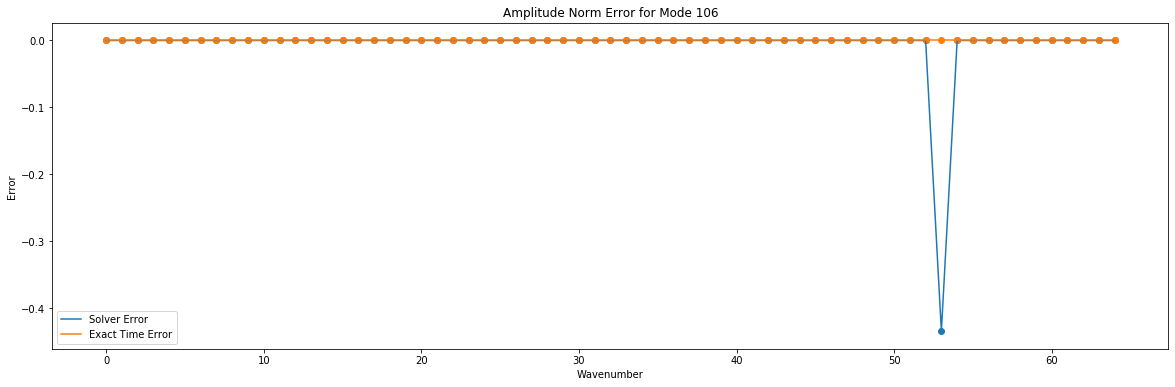

Actual:
[ 0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -2.00000000e-15  2.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15

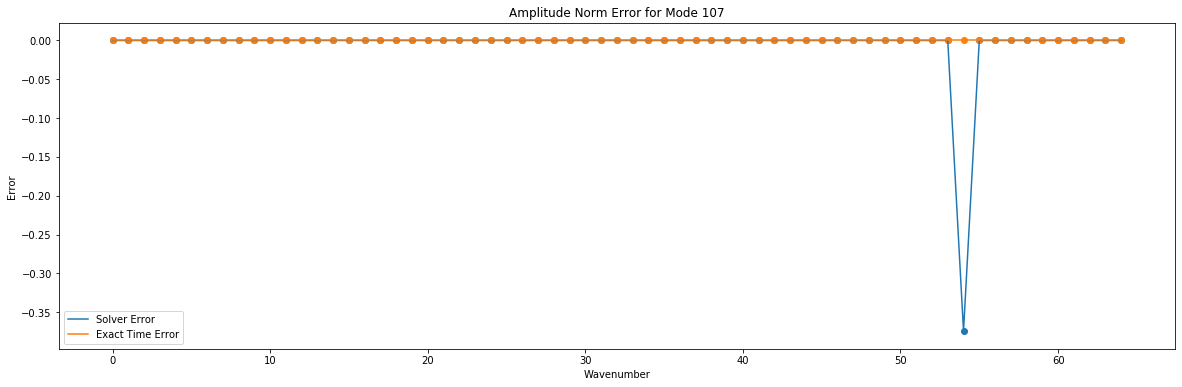

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -2.00000000e-15 -1.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -2.00000000e-15

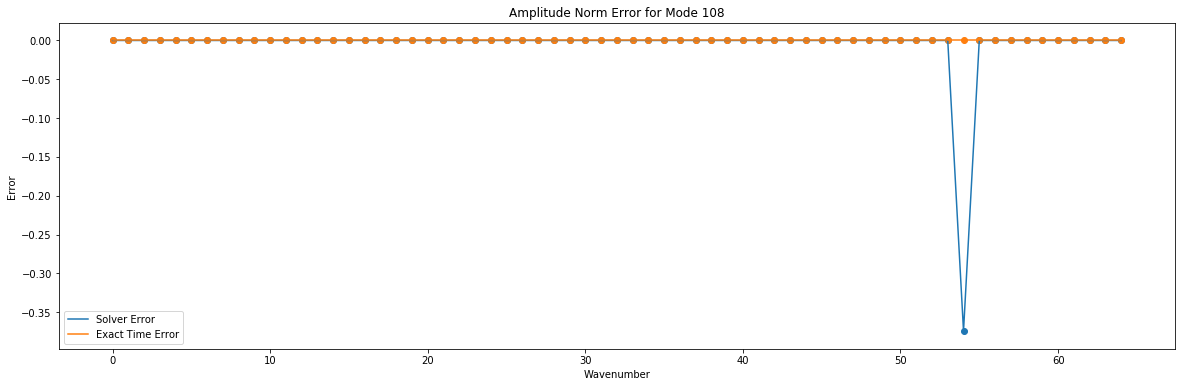

Actual:
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00

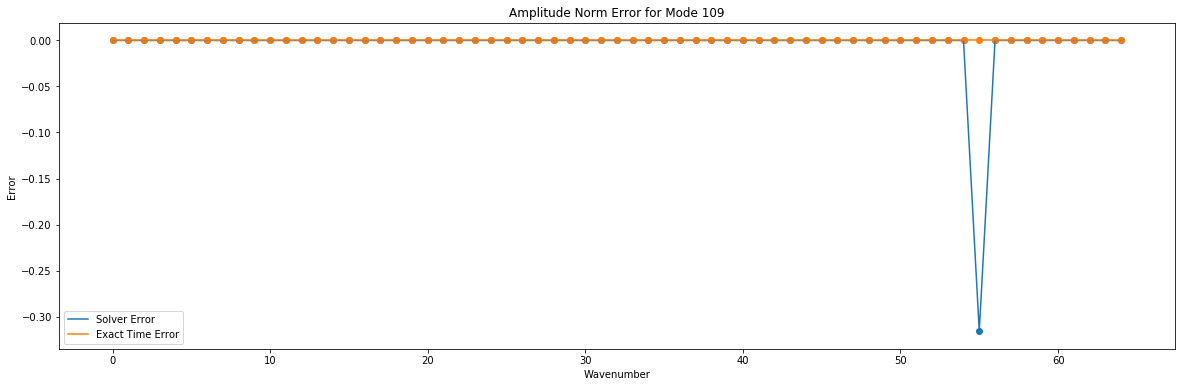

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15

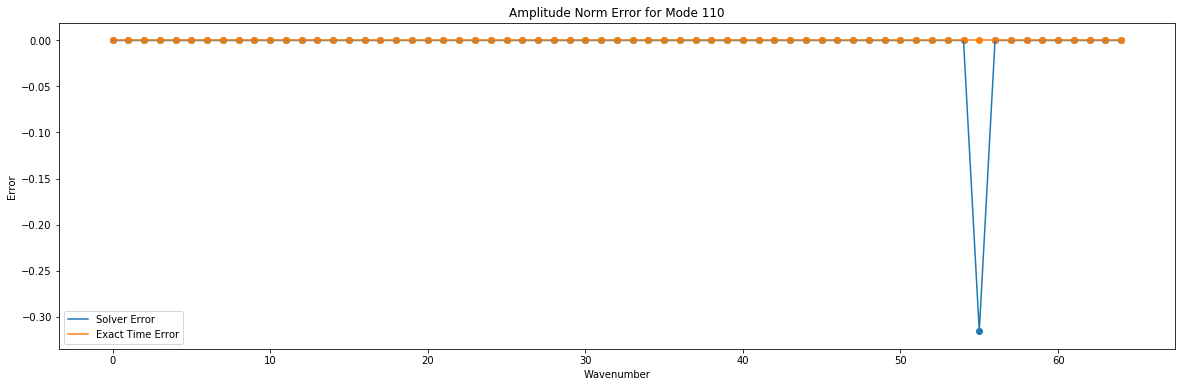

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.00000000e-15 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -2.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00

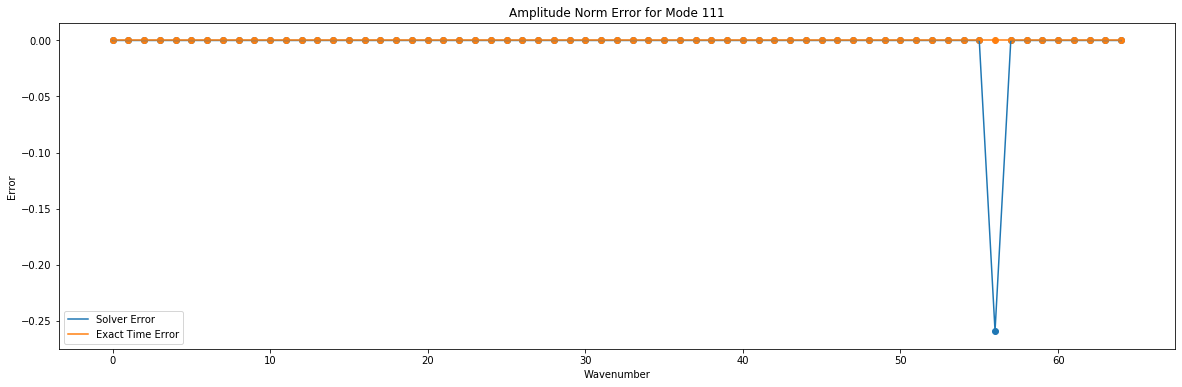

Actual:
[-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00

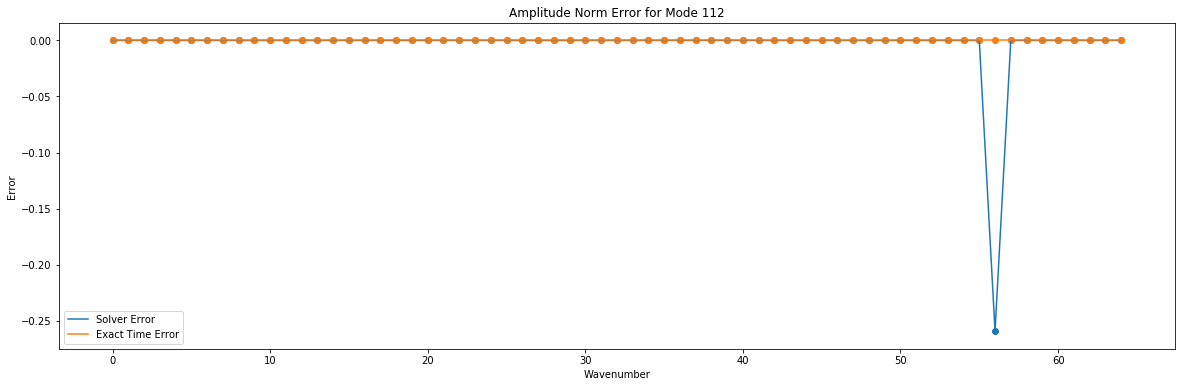

Actual:
[-0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  2.00000000e-15  1.00000000e-15 -1.00000000e-15 -0.00000000e+00  2.00000000e-15 -1.00000000e-15 -2.00000000e-15  2.00000000e-15 -1.00000000e-15  3.00000000e-15  3.00000000e-15 -1.00000000e-15  3.00000000e-15 -2.00000000e-15

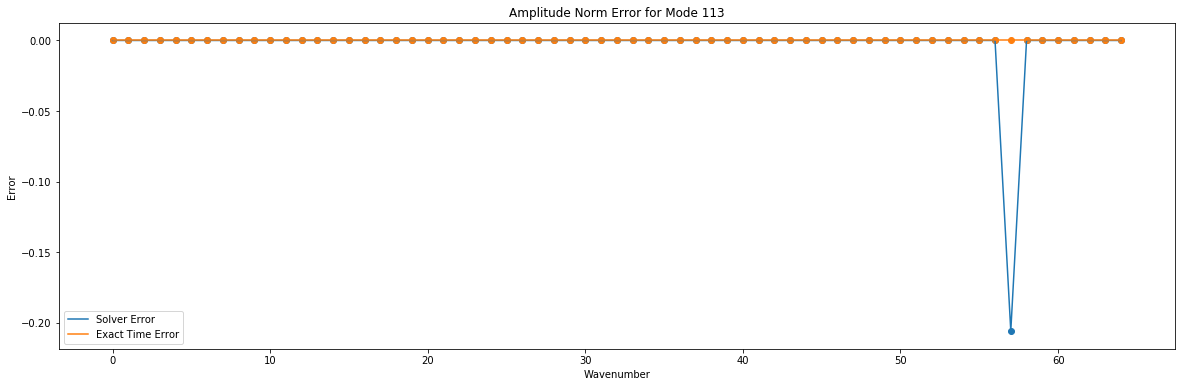

Actual:
[-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15 -1.00000000e-15  3.00000000e-15  1.00000000e-15 -2.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  2.00000000e-15 -3.00000000e-15  2.00000000e-15  1.00000000e-15  2.00000000e-15

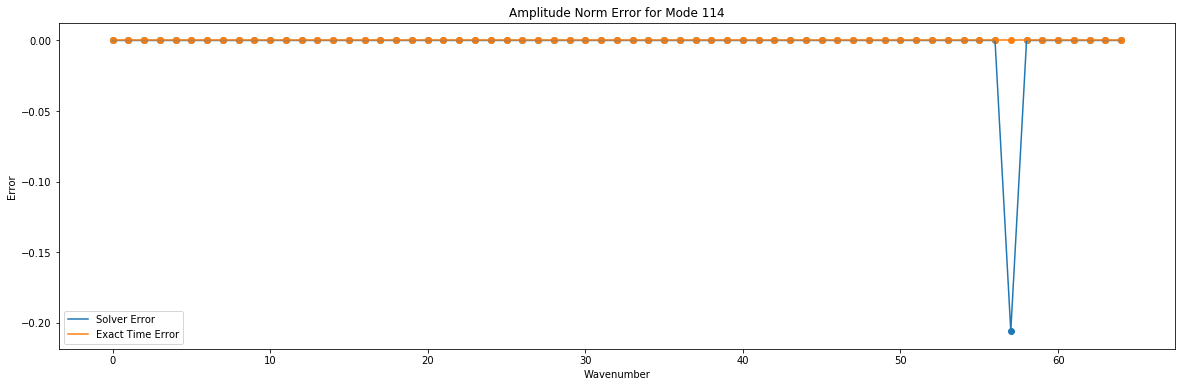

Actual:
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -1.00000000e-15  1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.00000000e-15

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -1.00000008e-10 -2.00000017e-10 -6.50000054e-10 -2.50000021e-10 -2.00000017e-10  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -5.00000041e-11 -1.00000008e-10 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11 -5.00000041e-11  0.00000000e+00  0.00000000e+00 -5.00000041e-11  0.00000000e+00 -5.00000041e-11  0.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00 -5.00000041e-11 -5.0000

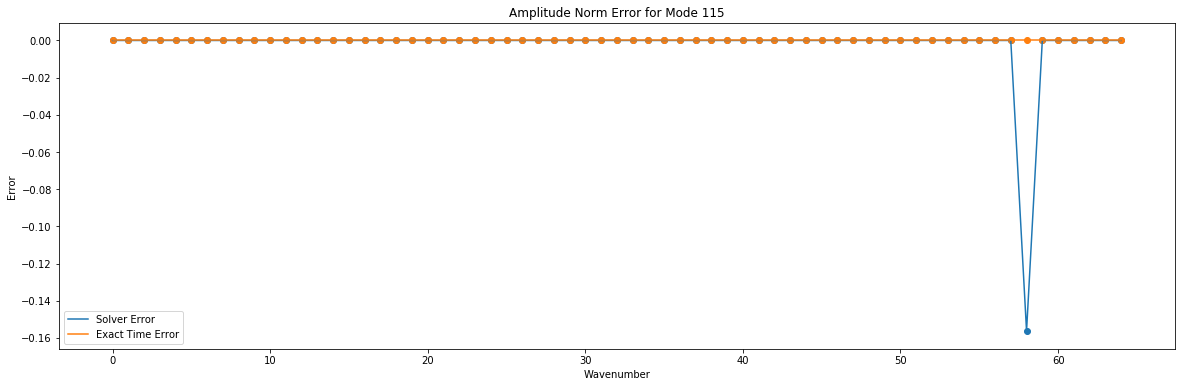

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -2.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15

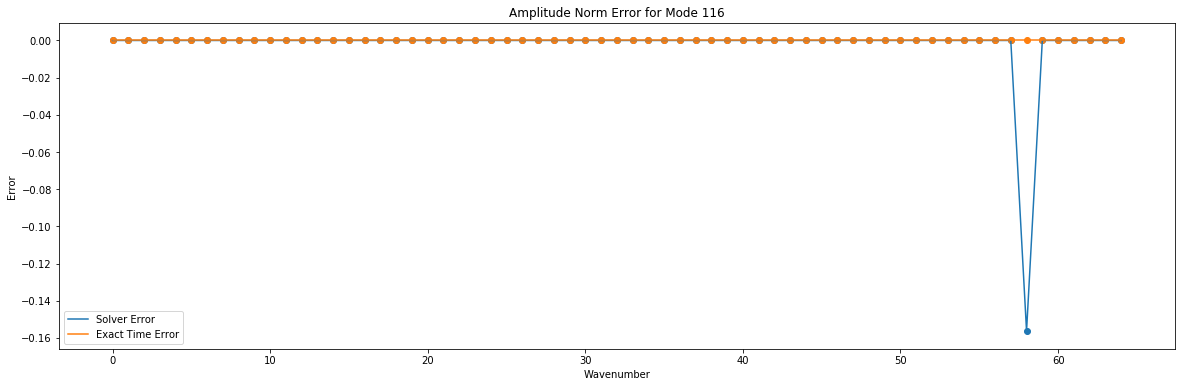

Actual:
[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e-15 -0.0000000e+00  0.0000000e+00 -1.0000000e-15 -0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  2.0000000e-15 -1.0000000e-15 -1.0000000e-15 -0.0000000e+00 -1.0000000e-15  0.0000000e+00  1.0000000e-15 -1.0000000e-15 -0.0000000e+00 -1.0000000e-15  0.0000000e+00 -1.0000000e-15 -1.0000000e-15 -1.0000000e-15 -0.0000000e+00 -1.0000000e-15 -2.0000000e-15 -0.0000000e+00 -

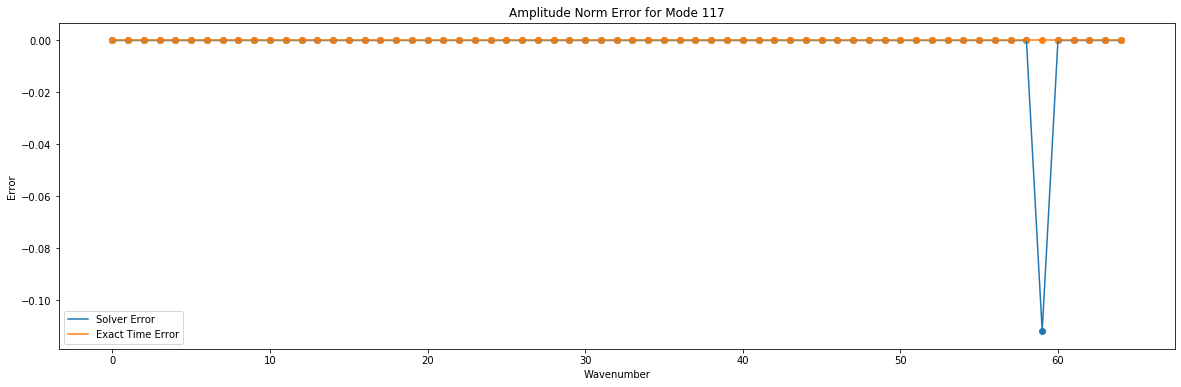

Actual:
[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15  0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -1.0000000e-15  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00  1.0000000e-15 -0.0000000e+00  1.0000000e-15 -1.0000000e-15 -1.0000000e-15 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15 -0.0000000e+00  0.0000000e+00 -1.0000000e-15  0.0000000e+00 -0.0000000e+00 -1.0000000e-15 -1.0000000e-15 -1.0000000e-15  0.0000000e+00 -0.0000000e+00 -1.0000000e-15  0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.0000000e-15  0.0000000e+00 -0.0000000e+00 -0.0000000e+00  1.0000000e-15  0.0000000e+00  0.0000000e+00 -3.0000000e-15  0.0000000e+00  0.0000000e+00 -

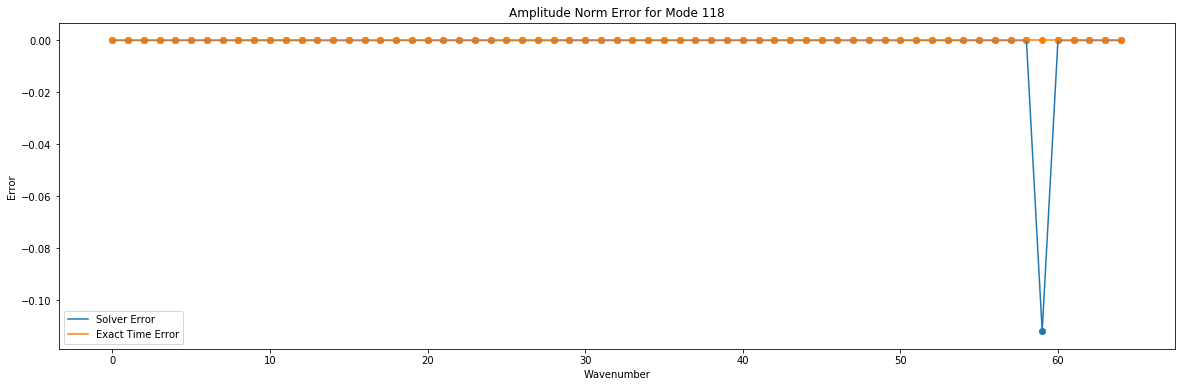

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00

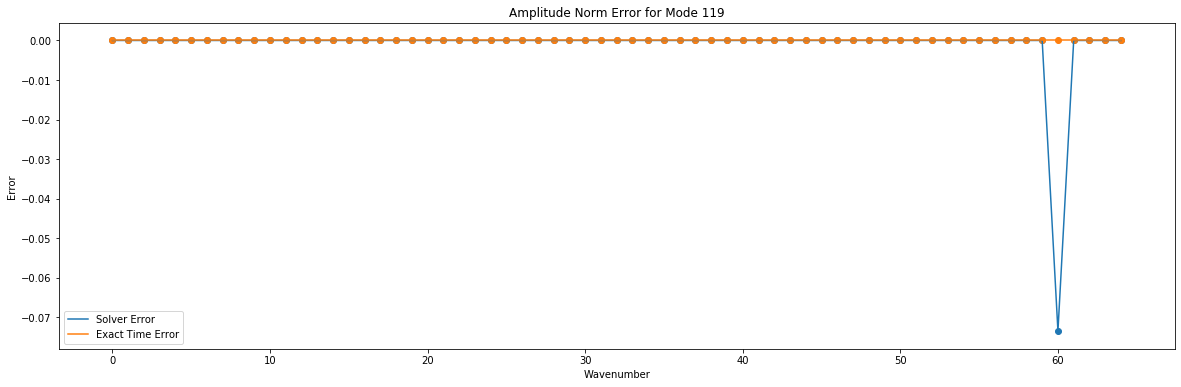

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -2.00000000e-15

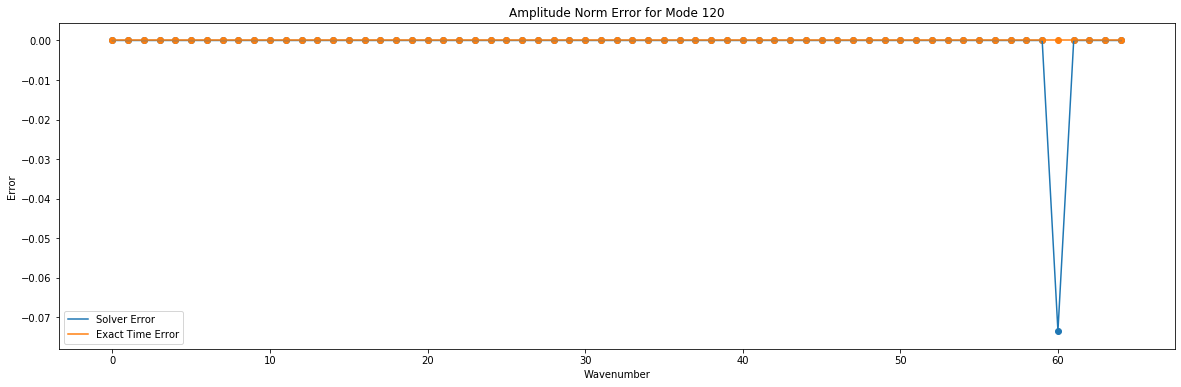

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00

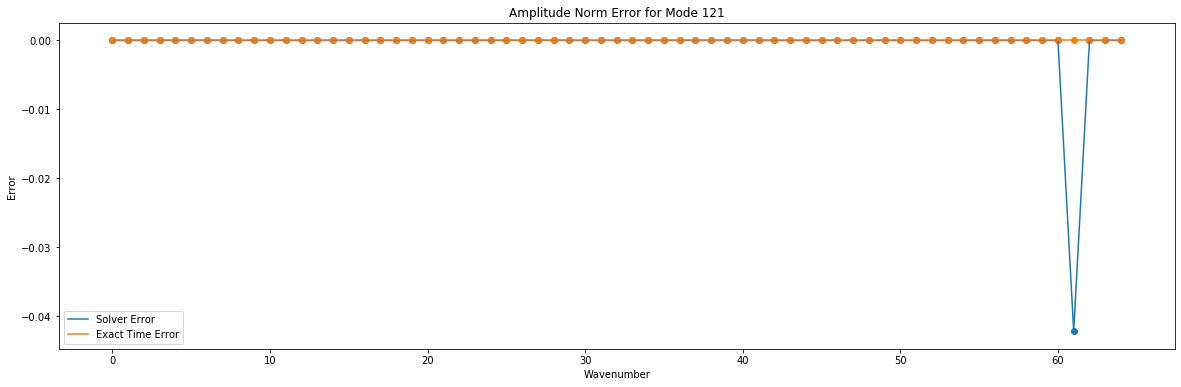

Actual:
[-0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15

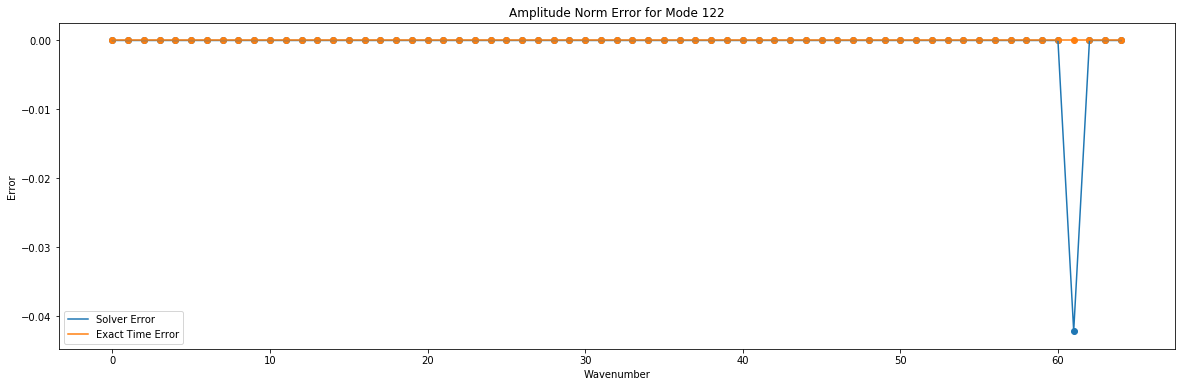

Actual:
[-0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15  1.00000000e-15  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  1.00000000e-15  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15 -2.00000000e-15 -0.00000000e+00  1.00000000e-15  1.00000000e-15 -1.00000000e-15  1.00000000e-15 -1.00000000e-15  2.00000000e-15

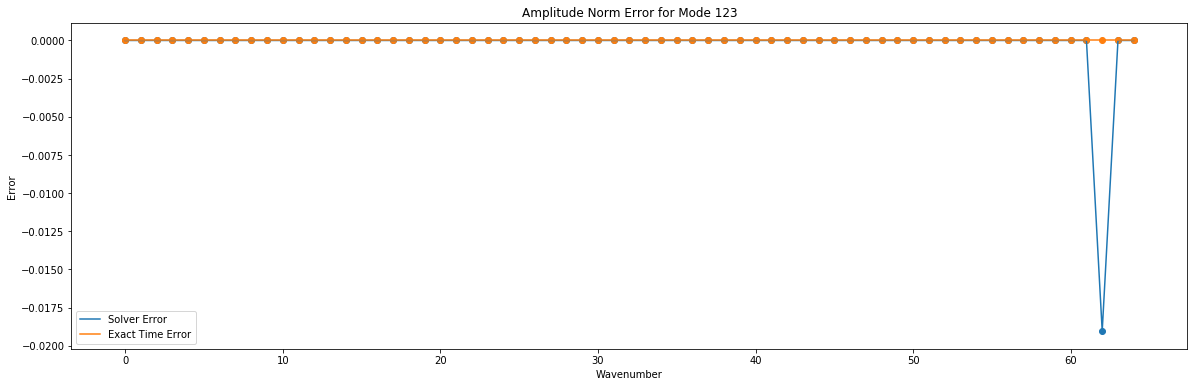

Actual:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00 -2.00000000e-15  2.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  2.00000000e-15 -2.00000000e-15 -0.00000000e+00  2.00000000e-15

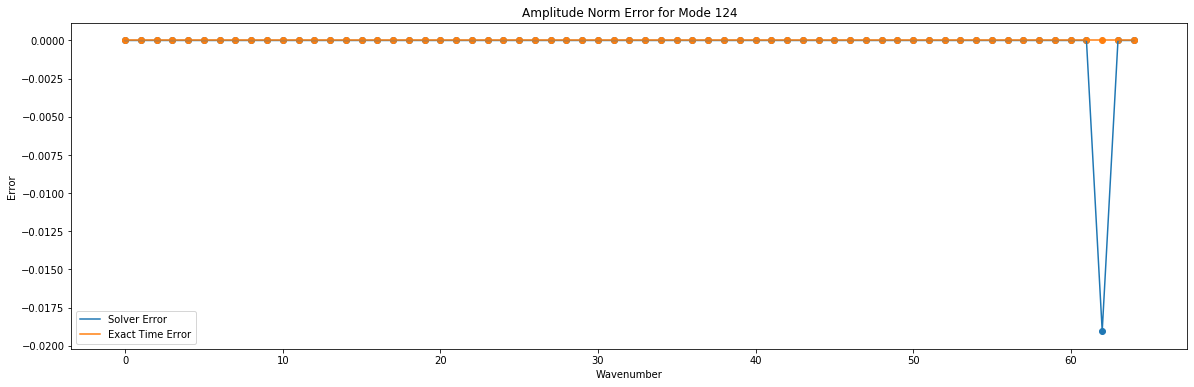

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.00000000e-15  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15 -0.00000000e+00 -1.00000000e-15  0.00000000e+00 -1.00000000e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15

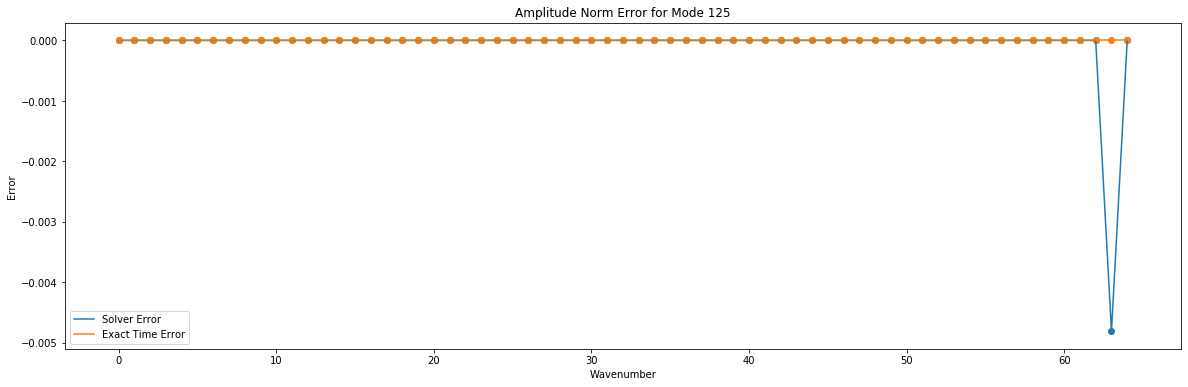

Actual:
[-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-15 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00  0.00000000e+00  1.00000000e-15  0.00000000e+00 -0.00000000e+00  1.00000000e-15  0.00000000e+00  1.00000000e-15 -0.00000000e+00  1.00000000e-15 -1.00000000e-15  0.00000000e+00  1.00000000e-15  0.00000000e+00  0.00000000e+00  1.00000000e-15 -0.00000000e+00

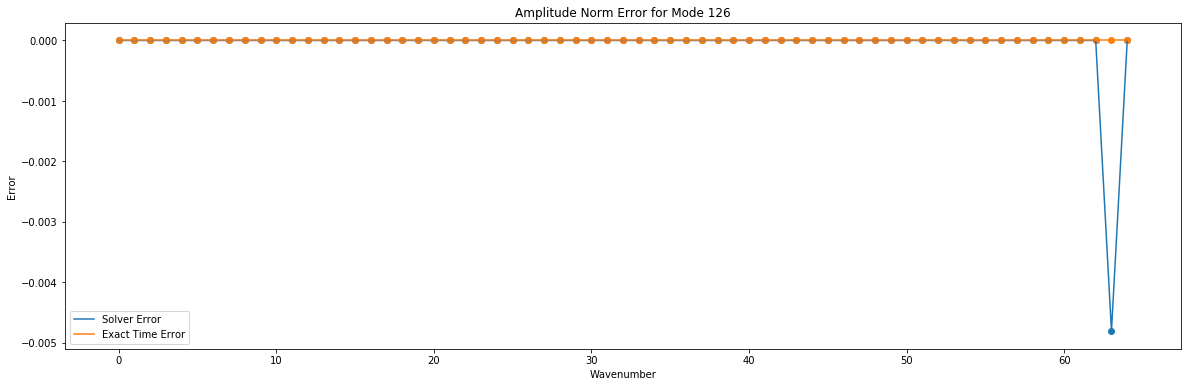

Actual:
[-0.e+00  0.e+00  1.e-15  0.e+00  0.e+00  0.e+00 -0.e+00  1.e-15  0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  1.e-15 -0.e+00 -0.e+00 -0.e+00 -0.e+00  1.e-15 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  1.e-15 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00 -0.e+00 -0.e+00  0.e+00 -0.e+00  0.e+00

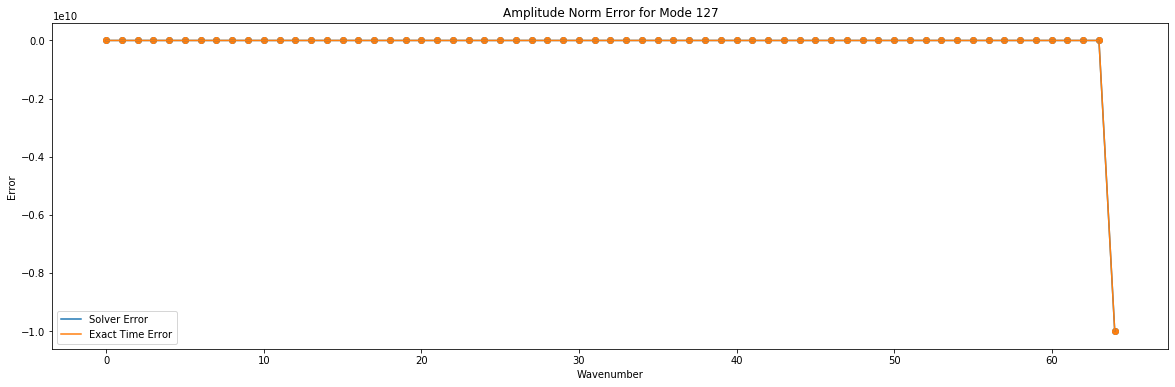

In [6]:
ks, solvError, exTimeError, solvNorm = ModeError(omega, nt, c, CFL, deriv, RK)

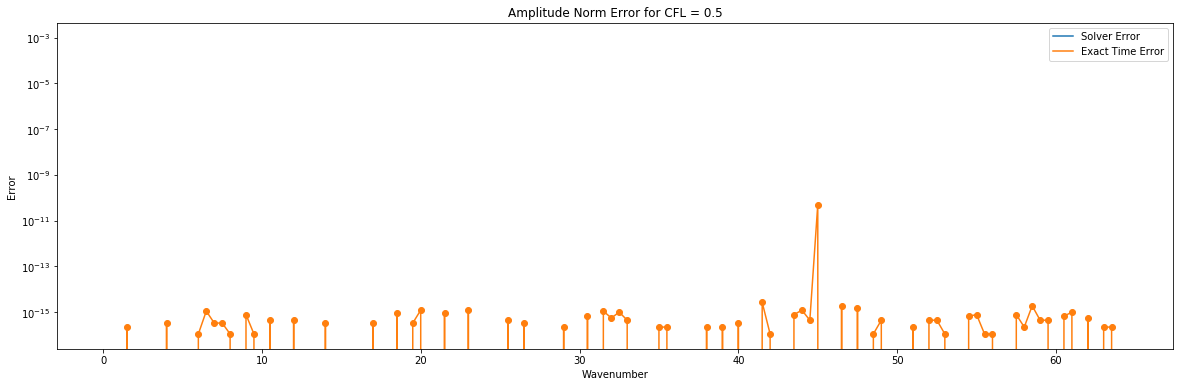

In [7]:
title = 'Amplitude Norm Error for CFL = ' + str(CFL)
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvError, label = 'Solver Error', color = PT.ColorDefault(0))
plt.scatter(ks, solvError, color = PT.ColorDefault(0))
plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Error')
plt.legend()
#plt.ylim(-1, 1.1)
plt.yscale('log')
plt.show()

In [8]:
def SolverAmpTheoretical(omega, RK, deriv, CFL):
    nh_max = omega.nh_max
    ks = np.arange((nh_max / 2) + 1)
    theta = (2 * np.pi * ks) / nh_max
    if (deriv == 'U'):
        print('Upwind', RK)
        x = CFL * (1 - np.exp(-1j * theta))
    else:
        x = 0.5 * CFL * (np.exp(1j * theta) - np.exp(-1j * theta))
    coefs = np.arange(RK + 1)[::-1]
    coefs = sp.special.factorial(coefs)**-1
    coefs[1::2] = -coefs[1::2]
    print(coefs)
    p = np.poly1d(coefs)
    print(p)
    amps = p(x)
    return ks, amps

In [9]:
ksT, amps = SolverAmpTheoretical(omega, RK, deriv, CFL)

[ 1. -1.]
 
1 x - 1


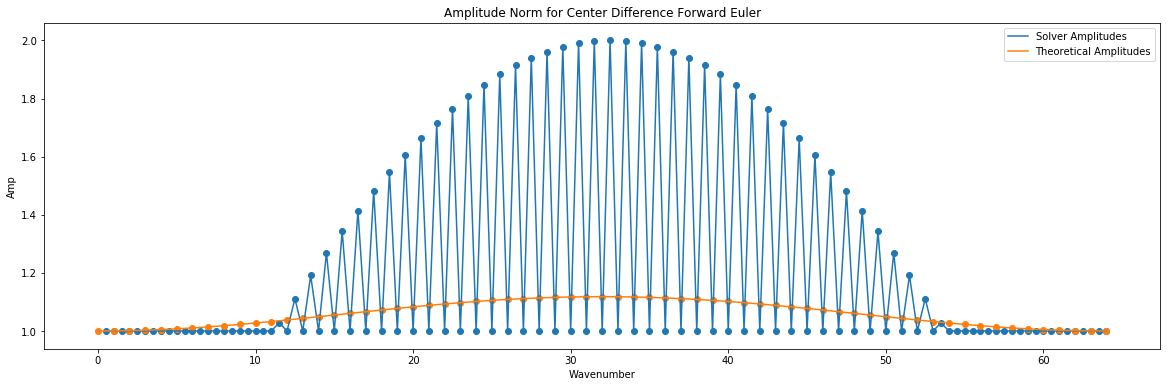

In [10]:
numPoints, font, X, savePath = PT.UsefulPlotVals()
title1 = 'Amplitude Norm for '
if (deriv == 'U'):
    title2 = 'Upwind '
    saveName1 = 'UW'
else:
    title2 = 'Center Difference '
    saveName1 = 'CD'
if (RK == 1):
    title3 = 'Forward Euler'
else:
    if (RK == 2):
        title3 = 'Midpoint Method'
    else:
        title3 = 'Fourth-Order Runge-Kutta'
saveName = savePath + saveName1 + 'RK' + str(RK) + '.png'
title = title1 + title2 + title3
fig, ax = plt.subplots(figsize = [20, 6])
plt.plot(ks, solvNorm, label = 'Solver Amplitudes', color = PT.ColorDefault(0))
plt.scatter(ks, solvNorm, color = PT.ColorDefault(0))
plt.plot(ksT, abs(amps), label = 'Theoretical Amplitudes', color = PT.ColorDefault(1))
plt.scatter(ksT, abs(amps), color = PT.ColorDefault(1))
# plt.plot(ksT, np.imag(amps), label = 'Imaginary Amplitudes', color = PT.ColorDefault(2))
# plt.scatter(ksT, np.imag(amps), color = PT.ColorDefault(2))
# plt.plot(ks, exTimeError, label = 'Exact Time Error', color = PT.ColorDefault(1))
# plt.scatter(ks, exTimeError, color = PT.ColorDefault(1))
plt.title(title)
plt.xlabel('Wavenumber')
plt.ylabel('Amp')
plt.legend()
fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
# plt.ylim(-10, 1000)
# plt.yscale('log')
plt.show()